In [1]:
import fastf1 
import pandas as pd
import numpy as np

from fastf1 import get_session

import matplotlib.pyplot as plt
import seaborn as sns

fastf1.Cache.enable_cache('E:\School Stuff\F1cache')

In [3]:
from f1_etl import SessionConfig, DataConfig, create_safety_car_dataset

# Define a single race session
session = SessionConfig(
    year=2024,
    race="Monaco Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="./f1_cache"
)

# Generate the dataset
dataset = create_safety_car_dataset(
    config=config,
    window_size=100,
    prediction_horizon=10
)

print(f"Generated {dataset['config']['n_sequences']} sequences")
print(f"Features: {dataset['config']['feature_names']}")
print(f"Class distribution: {dataset['class_distribution']}")

Loading session: 2024 Monaco Grand Prix R


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
2025-06-28 15:27:36,202 - f1_etl - INFO - Processing 1833280 to

Generated 36640 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': 29900, 'red': 5780, 'safety_car': 320, 'yellow': 640}


In [13]:
df = pd.DataFrame(dataset['raw_telemetry'])

In [15]:
df.columns

Index(['Date', 'Status_x', 'X', 'Y', 'Z', 'Source', 'Time', 'SessionTime',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Distance',
       'DifferentialDistance', 'Driver', 'SessionYear', 'SessionRace',
       'SessionType', 'SessionId', 'TrackStatus', 'TrackStatusMessage',
       'TrackStatusEncoded'],
      dtype='object')

In [21]:
ver = df[df['Driver'] == '1']
ver.head()

,Date,Status_x,X,Y,Z,Source,Time,SessionTime,RPM,Speed,...,Distance,DifferentialDistance,Driver,SessionYear,SessionRace,SessionType,SessionId,TrackStatus,TrackStatusMessage,TrackStatusEncoded
13,2024-05-26 12:08:08.143,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00,0 days 00:00:02.754000,0.0,0.0,...,0.0,0.0,1,2024,Monaco Grand Prix,R,2024_Monaco Grand Prix_R,1,AllClear,0
33,2024-05-26 12:08:08.225,OnTrack,0.0,0.0,0.0,car,0 days 00:00:00.082000,0 days 00:00:02.836000,0.0,0.0,...,0.0,0.0,1,2024,Monaco Grand Prix,R,2024_Monaco Grand Prix_R,1,AllClear,0
58,2024-05-26 12:08:08.323,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.180000,0 days 00:00:02.934000,0.0,0.0,...,0.0,0.0,1,2024,Monaco Grand Prix,R,2024_Monaco Grand Prix_R,1,AllClear,0
73,2024-05-26 12:08:08.503,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.360000,0 days 00:00:03.114000,0.0,0.0,...,0.0,0.0,1,2024,Monaco Grand Prix,R,2024_Monaco Grand Prix_R,1,AllClear,0
89,2024-05-26 12:08:08.505,OnTrack,0.0,0.0,0.0,car,0 days 00:00:00.362000,0 days 00:00:03.116000,0.0,0.0,...,0.0,0.0,1,2024,Monaco Grand Prix,R,2024_Monaco Grand Prix_R,1,AllClear,0


In [22]:
def calculate_f1_gforce(df, smooth_window=7):
    """
    Calculate G-forces from F1 telemetry data using multiple methods
    
    Parameters:
    df: DataFrame with F1 telemetry columns
    smooth_window: window size for smoothing (larger = smoother but less responsive)
    
    Returns:
    DataFrame with added G-force columns
    """
    
    # Make a copy to avoid modifying original
    df_calc = df.copy()
    
    # Convert time to seconds for calculations
    time_seconds = pd.to_timedelta(df_calc['Time']).dt.total_seconds()
    dt = time_seconds.diff()
    
    # Method 1: Speed-based longitudinal G-force (most reliable)
    # Convert speed from km/h to m/s if needed
    if df_calc['Speed'].max() > 50:  # Likely km/h
        speed_ms = df_calc['Speed'] / 3.6
    else:
        speed_ms = df_calc['Speed']
    
    # Smooth speed to reduce noise
    speed_smooth = speed_ms.rolling(window=smooth_window, center=True).mean()
    
    # Calculate longitudinal acceleration from speed
    longitudinal_accel = speed_smooth.diff() / dt
    df_calc['g_force_longitudinal'] = longitudinal_accel / 9.81
    
    # Method 2: Distance-based calculation (alternative)
    distance_smooth = df_calc['Distance'].rolling(window=smooth_window, center=True).mean()
    distance_velocity = distance_smooth.diff() / dt
    distance_accel = distance_velocity.diff() / dt
    df_calc['g_force_distance_based'] = distance_accel / 9.81
    
    # Method 3: Position-based (with heavy smoothing and unit conversion)
    # Convert X,Y from 1/10 meters to meters
    x_meters = df_calc['X'] / 10
    y_meters = df_calc['Y'] / 10
    z_meters = df_calc['Z']  # Assuming Z is already in meters
    
    # Heavy smoothing for position data
    x_smooth = x_meters.rolling(window=smooth_window*2, center=True).mean()
    y_smooth = y_meters.rolling(window=smooth_window*2, center=True).mean()
    z_smooth = z_meters.rolling(window=smooth_window*2, center=True).mean()
    
    # Calculate velocities
    vx = x_smooth.diff() / dt
    vy = y_smooth.diff() / dt
    vz = z_smooth.diff() / dt
    
    # Smooth velocities
    vx_smooth = vx.rolling(window=smooth_window, center=True).mean()
    vy_smooth = vy.rolling(window=smooth_window, center=True).mean()
    vz_smooth = vz.rolling(window=smooth_window, center=True).mean()
    
    # Calculate accelerations
    ax = vx_smooth.diff() / dt
    ay = vy_smooth.diff() / dt
    az = vz_smooth.diff() / dt
    
    # Convert to G-forces
    df_calc['g_force_x_pos'] = ax / 9.81  # Longitudinal from position
    df_calc['g_force_y_pos'] = ay / 9.81  # Lateral from position
    df_calc['g_force_z_pos'] = az / 9.81  # Vertical from position
    
    # Calculate total G-force magnitude from position
    df_calc['g_force_total_pos'] = np.sqrt(df_calc['g_force_x_pos']**2 + 
                                           df_calc['g_force_y_pos']**2 + 
                                           df_calc['g_force_z_pos']**2)
    
    # Method 4: Enhanced longitudinal using throttle/brake context
    # Combine speed-based G-force with throttle/brake for better accuracy
    df_calc['is_braking'] = df_calc['Brake'] > 0
    df_calc['is_accelerating'] = df_calc['Throttle'] > 50  # >50% throttle
    
    # Apply different smoothing based on driver input
    enhanced_gforce = df_calc['g_force_longitudinal'].copy()
    
    # Less smoothing during braking/acceleration (more responsive)
    braking_mask = df_calc['is_braking']
    accel_mask = df_calc['is_accelerating']
    
    if braking_mask.sum() > 0:
        enhanced_gforce[braking_mask] = (speed_ms.diff() / dt)[braking_mask] / 9.81
    
    df_calc['g_force_enhanced'] = enhanced_gforce.rolling(window=max(3, smooth_window//2), center=True).mean()
    
    return df_calc

def analyze_f1_gforce(df):
    """
    Analyze and compare different G-force calculation methods
    """
    print("=== F1 G-Force Analysis ===\n")
    
    # Filter out stationary data
    moving_data = df[df['Speed'] > 5]  # Only analyze when moving >5 km/h
    
    if len(moving_data) == 0:
        print("⚠️  No movement detected in data (Speed always ≤ 5 km/h)")
        print("G-force calculations will be minimal for stationary car")
        moving_data = df
    
    print(f"Analyzing {len(moving_data)} data points with movement\n")
    
    # Speed-based analysis (most reliable)
    print("📊 Speed-based Longitudinal G-Forces:")
    print(f"   Max acceleration: +{moving_data['g_force_longitudinal'].max():.2f}g")
    print(f"   Max braking: {moving_data['g_force_longitudinal'].min():.2f}g")
    print(f"   Average magnitude: {moving_data['g_force_longitudinal'].abs().mean():.2f}g\n")
    
    # Position-based analysis
    print("📊 Position-based G-Forces:")
    print(f"   Max longitudinal: {moving_data['g_force_x_pos'].max():.2f}g")
    print(f"   Min longitudinal: {moving_data['g_force_x_pos'].min():.2f}g")
    print(f"   Max lateral: ±{moving_data['g_force_y_pos'].abs().max():.2f}g")
    print(f"   Max total: {moving_data['g_force_total_pos'].max():.2f}g\n")
    
    # Driving context analysis
    braking_data = moving_data[moving_data['Brake'] > 0]
    accel_data = moving_data[moving_data['Throttle'] > 80]
    
    if len(braking_data) > 0:
        print(f"🛑 During braking ({len(braking_data)} points):")
        print(f"   Max braking G-force: {braking_data['g_force_enhanced'].min():.2f}g")
    
    if len(accel_data) > 0:
        print(f"🏁 During acceleration ({len(accel_data)} points):")
        print(f"   Max acceleration G-force: +{accel_data['g_force_enhanced'].max():.2f}g")
    
    # Data quality assessment
    print(f"\n🔍 Data Quality Assessment:")
    print(f"   Speed range: {df['Speed'].min():.1f} - {df['Speed'].max():.1f} km/h")
    print(f"   RPM range: {df['RPM'].min():.0f} - {df['RPM'].max():.0f}")
    print(f"   Gear range: {df['nGear'].min()} - {df['nGear'].max()}")
    print(f"   Throttle used: {(df['Throttle'] > 0).sum()}/{len(df)} points")
    print(f"   Brake used: {(df['Brake'] > 0).sum()}/{len(df)} points")

def plot_f1_gforce_comparison(df, time_range=None):
    """
    Plot comparison of different G-force calculation methods
    """
    if time_range:
        df_plot = df.iloc[time_range[0]:time_range[1]]
    else:
        df_plot = df
    
    time_seconds = pd.to_timedelta(df_plot['Time']).dt.total_seconds()
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Speed and driver inputs
    ax1 = axes[0, 0]
    ax1.plot(time_seconds, df_plot['Speed'], 'b-', label='Speed (km/h)')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(time_seconds, df_plot['Throttle'], 'g-', alpha=0.7, label='Throttle %')
    ax1_twin.plot(time_seconds, df_plot['Brake'], 'r-', alpha=0.7, label='Brake %')
    ax1.set_title('Speed & Driver Inputs')
    ax1.set_ylabel('Speed (km/h)')
    ax1_twin.set_ylabel('Throttle/Brake %')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True)
    
    # Longitudinal G-force comparison
    axes[0, 1].plot(time_seconds, df_plot['g_force_longitudinal'], 'b-', label='Speed-based', alpha=0.8)
    axes[0, 1].plot(time_seconds, df_plot['g_force_enhanced'], 'r-', label='Enhanced', alpha=0.8)
    axes[0, 1].plot(time_seconds, df_plot['g_force_distance_based'], 'g-', label='Distance-based', alpha=0.6)
    axes[0, 1].set_title('Longitudinal G-Force Comparison')
    axes[0, 1].set_ylabel('G-Force')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Position-based G-forces
    axes[1, 0].plot(time_seconds, df_plot['g_force_x_pos'], 'b-', label='Longitudinal (X)')
    axes[1, 0].plot(time_seconds, df_plot['g_force_y_pos'], 'r-', label='Lateral (Y)')
    axes[1, 0].set_title('Position-based G-Forces')
    axes[1, 0].set_ylabel('G-Force')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Total G-force
    axes[1, 1].plot(time_seconds, df_plot['g_force_total_pos'], 'purple', label='Total G-Force')
    axes[1, 1].set_title('Total G-Force Magnitude')
    axes[1, 1].set_ylabel('G-Force')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # RPM and Gear
    ax2 = axes[2, 0]
    ax2.plot(time_seconds, df_plot['RPM'], 'orange', label='RPM')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(time_seconds, df_plot['nGear'], 'ko-', markersize=3, label='Gear')
    ax2.set_title('RPM & Gear')
    ax2.set_ylabel('RPM')
    ax2_twin.set_ylabel('Gear')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True)
    
    # G-force vs Speed scatter
    moving_mask = df_plot['Speed'] > 5
    axes[2, 1].scatter(df_plot[moving_mask]['Speed'], df_plot[moving_mask]['g_force_enhanced'], 
                       c=df_plot[moving_mask]['Throttle'], cmap='RdYlGn', alpha=0.6, s=20)
    axes[2, 1].set_title('G-Force vs Speed (colored by Throttle)')
    axes[2, 1].set_xlabel('Speed (km/h)')
    axes[2, 1].set_ylabel('Longitudinal G-Force')
    axes[2, 1].grid(True)
    axes[2, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# df_with_gforce = calculate_f1_gforce(your_df, smooth_window=5)
# analyze_f1_gforce(df_with_gforce)
# plot_f1_gforce_comparison(df_with_gforce)

# For just a specific time range:
# plot_f1_gforce_comparison(df_with_gforce, time_range=(100, 500))

In [23]:
df_with_gforce = calculate_f1_gforce(ver, smooth_window=5)

In [24]:
analyze_f1_gforce(df_with_gforce)

=== F1 G-Force Analysis ===

Analyzing 52523 data points with movement

📊 Speed-based Longitudinal G-Forces:
   Max acceleration: +236.83g
   Max braking: -339.79g
   Average magnitude: 2.30g

📊 Position-based G-Forces:
   Max longitudinal: 211326.98g
   Min longitudinal: -85015.32g
   Max lateral: ±140930.44g
   Max total: 250001.81g

🛑 During braking (13466 points):
   Max braking G-force: -61.04g
🏁 During acceleration (15721 points):
   Max acceleration G-force: +85.64g

🔍 Data Quality Assessment:
   Speed range: 0.0 - 292.0 km/h
   RPM range: 0 - 12327
   Gear range: 0 - 7
   Throttle used: 34092/91664 points
   Brake used: 15229/91664 points


In [52]:
def debug_gforce_calculation(df):
    """
    Debug the G-force calculation to find what's causing unrealistic values
    """
    print("=== DEBUGGING G-FORCE CALCULATION ===\n")
    
    # Convert time to seconds
    time_seconds = pd.to_timedelta(df['Time']).dt.total_seconds()
    dt = time_seconds.diff()
    
    print("🕐 Time Analysis:")
    print(f"   Time range: {time_seconds.min():.3f}s to {time_seconds.max():.3f}s")
    print(f"   Time intervals (dt):")
    print(f"     Min: {dt.min():.6f}s")
    print(f"     Max: {dt.max():.6f}s") 
    print(f"     Mean: {dt.mean():.6f}s")
    print(f"     Median: {dt.median():.6f}s")
    print(f"   Very small dt count (< 0.001s): {(dt < 0.001).sum()}")
    print(f"   Zero dt count: {(dt == 0).sum()}")
    
    # Speed analysis
    print(f"\n🏎️ Speed Analysis:")
    print(f"   Raw speed range: {df['Speed'].min():.1f} to {df['Speed'].max():.1f}")
    print(f"   Speed jumps > 50 km/h in one step: {(df['Speed'].diff().abs() > 50).sum()}")
    print(f"   Speed jumps > 100 km/h in one step: {(df['Speed'].diff().abs() > 100).sum()}")
    
    # Look at speed changes
    speed_changes = df['Speed'].diff()
    print(f"   Largest speed increase: {speed_changes.max():.1f} km/h")
    print(f"   Largest speed decrease: {speed_changes.min():.1f} km/h")
    
    # Convert speed to m/s
    speed_ms = df['Speed'] / 3.6
    speed_change_ms = speed_ms.diff()
    
    print(f"   Speed changes in m/s:")
    print(f"     Max increase: {speed_change_ms.max():.1f} m/s")
    print(f"     Max decrease: {speed_change_ms.min():.1f} m/s")
    
    # Calculate raw acceleration
    raw_accel = speed_change_ms / dt
    print(f"\n⚡ Raw Acceleration Analysis:")
    print(f"   Max acceleration: {raw_accel.max():.1f} m/s²")
    print(f"   Min acceleration: {raw_accel.min():.1f} m/s²")
    print(f"   Accelerations > 100 m/s²: {(raw_accel.abs() > 100).sum()}")
    print(f"   Accelerations > 50 m/s²: {(raw_accel.abs() > 50).sum()}")
    
    # Look for problematic data points
    extreme_accel = raw_accel.abs() > 50  # > ~5G is suspicious
    if extreme_accel.sum() > 0:
        print(f"\n🚨 Found {extreme_accel.sum()} extreme acceleration points:")
        extreme_indices = np.where(extreme_accel)[0]
        for i in extreme_indices[:5]:  # Show first 5
            if i > 0:
                print(f"   Index {i}: dt={dt.iloc[i]:.6f}s, speed_change={speed_change_ms.iloc[i]:.1f}m/s, accel={raw_accel.iloc[i]:.1f}m/s²")
    
    return dt, speed_ms, raw_accel

def plot_debug_data(df, dt, speed_ms, raw_accel, start_idx=1000, end_idx=1200):
    """
    Plot a small section of data to see what's happening
    """
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    indices = range(start_idx, min(end_idx, len(df)))
    
    # Time intervals
    axes[0].plot(indices, dt.iloc[start_idx:end_idx], 'b-')
    axes[0].set_title('Time Intervals (dt)')
    axes[0].set_ylabel('dt (seconds)')
    axes[0].grid(True)
    
    # Speed
    axes[1].plot(indices, df['Speed'].iloc[start_idx:end_idx], 'g-')
    axes[1].set_title('Speed')
    axes[1].set_ylabel('Speed (km/h)')
    axes[1].grid(True)
    
    # Speed changes
    speed_changes = speed_ms.diff()
    axes[2].plot(indices, speed_changes.iloc[start_idx:end_idx], 'orange')
    axes[2].set_title('Speed Changes')
    axes[2].set_ylabel('Speed change (m/s)')
    axes[2].grid(True)
    
    # Raw acceleration (clipped for visibility)
    accel_clipped = np.clip(raw_accel, -100, 100)
    axes[3].plot(indices, accel_clipped.iloc[start_idx:end_idx], 'r-')
    axes[3].set_title('Raw Acceleration (clipped to ±100 m/s²)')
    axes[3].set_ylabel('Acceleration (m/s²)')
    axes[3].set_xlabel('Data Point Index')
    axes[3].grid(True)
    axes[3].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def calculate_realistic_gforce(df, min_dt=0.01):
    """
    Calculate G-force with better filtering to remove unrealistic spikes
    """
    df_calc = df.copy()
    
    # Convert time to seconds
    time_seconds = pd.to_timedelta(df_calc['Time']).dt.total_seconds()
    dt = time_seconds.diff()
    
    # Filter out extremely small time intervals that cause spikes
    dt_filtered = dt.copy()
    dt_filtered[dt < min_dt] = np.nan
    
    # Convert speed to m/s
    speed_ms = df_calc['Speed'] / 3.6
    
    # Apply heavy smoothing to speed first
    speed_smooth = speed_ms.rolling(window=10, center=True).mean()
    
    # Calculate acceleration with filtered dt
    acceleration = speed_smooth.diff() / dt_filtered
    
    # Remove extreme outliers (> 6G is very suspicious for F1)
    acceleration_filtered = acceleration.copy()
    acceleration_filtered[acceleration.abs() > 60] = np.nan  # > 6G
    
    # Apply additional smoothing
    acceleration_smooth = acceleration_filtered.rolling(window=5, center=True).mean()
    
    # Convert to G-force
    df_calc['g_force_realistic'] = acceleration_smooth / 9.81
    
    # Also calculate a simple moving average version
    window_size = 20  # Larger window for very smooth result
    speed_very_smooth = speed_ms.rolling(window=window_size, center=True).mean()
    accel_very_smooth = speed_very_smooth.diff() / dt_filtered
    df_calc['g_force_very_smooth'] = accel_very_smooth / 9.81
    
    return df_calc

def calculate_lateral_gforce(df, method='curvature', max_realistic_g=6.0):
    """
    Calculate lateral G-forces using different methods with realistic filtering
    
    Parameters:
    df: DataFrame with F1 telemetry
    method: 'curvature' or 'position' or 'both'
    max_realistic_g: Maximum realistic G-force to allow (default 6.0g for F1)
    """
    df_calc = df.copy()
    
    # Convert time to seconds
    time_seconds = pd.to_timedelta(df_calc['Time']).dt.total_seconds()
    dt = time_seconds.diff()
    dt_filtered = dt.copy()
    dt_filtered[dt < 0.01] = np.nan  # More aggressive filtering of tiny intervals
    
    # Convert speed to m/s
    speed_ms = df_calc['Speed'] / 3.6
    
    if method in ['curvature', 'both']:
        # Method 1: Calculate from track curvature with heavy filtering
        x_m = df_calc['X'] / 10  # Convert from 1/10 meters
        y_m = df_calc['Y'] / 10
        
        # Much heavier smoothing for position data to reduce GPS noise
        window = 25  # Larger window
        x_smooth = x_m.rolling(window=window, center=True).mean()
        y_smooth = y_m.rolling(window=window, center=True).mean()
        
        # Apply additional median filtering to remove spikes
        x_smooth = x_smooth.rolling(window=7, center=True).median()
        y_smooth = y_smooth.rolling(window=7, center=True).median()
        
        # Calculate velocity components (first derivatives)
        vx = x_smooth.diff() / dt_filtered
        vy = y_smooth.diff() / dt_filtered
        
        # Smooth velocities heavily
        vx_smooth = vx.rolling(window=15, center=True).mean()
        vy_smooth = vy.rolling(window=15, center=True).mean()
        
        # Calculate speed from position derivatives
        speed_from_position = np.sqrt(vx_smooth**2 + vy_smooth**2)
        
        # Only calculate curvature when we have reasonable speed
        speed_threshold = 5.0  # m/s (18 km/h)
        valid_speed_mask = speed_from_position > speed_threshold
        
        # Calculate acceleration components (second derivatives)
        ax = vx_smooth.diff() / dt_filtered
        ay = vy_smooth.diff() / dt_filtered
        
        # Calculate centripetal acceleration (perpendicular to velocity)
        # a_centripetal = (vx*ay - vy*ax) / |v|
        velocity_magnitude = np.sqrt(vx_smooth**2 + vy_smooth**2)
        
        # Avoid division by very small velocities
        velocity_magnitude[velocity_magnitude < speed_threshold] = np.nan
        
        # Centripetal acceleration formula
        centripetal_accel = np.abs(vx_smooth * ay - vy_smooth * ax) / velocity_magnitude
        
        # Alternative method: use curvature formula
        # Calculate curvature: κ = |x'y'' - y'x''| / (x'² + y'²)^(3/2)
        d2x_dt2 = vx_smooth.diff() / dt_filtered
        d2y_dt2 = vy_smooth.diff() / dt_filtered
        
        numerator = np.abs(vx_smooth * d2y_dt2 - vy_smooth * d2x_dt2)
        denominator = (vx_smooth**2 + vy_smooth**2)**(3/2)
        
        # Avoid division by zero or very small numbers
        denominator[denominator < 1e-6] = np.nan
        curvature = numerator / denominator
        curvature = curvature.fillna(0)
        
        # Use actual speed from telemetry (more reliable than position-derived speed)
        # But apply sanity check
        speed_for_calc = speed_ms.copy()
        speed_for_calc[~valid_speed_mask] = 0
        
        # Calculate lateral acceleration = speed² × curvature
        lateral_accel_curv = speed_for_calc**2 * curvature
        
        # Apply multiple filtering stages
        lateral_accel_filtered = lateral_accel_curv.copy()
        
        # Stage 1: Remove obviously unrealistic values
        max_accel = max_realistic_g * 9.81  # Convert G to m/s²
        lateral_accel_filtered[lateral_accel_filtered > max_accel * 2] = np.nan  # Remove extreme outliers
        
        # Stage 2: Apply percentile-based filtering
        percentile_99 = np.nanpercentile(lateral_accel_filtered, 99)
        if percentile_99 > max_accel:
            lateral_accel_filtered[lateral_accel_filtered > max_accel] = max_accel
        
        # Stage 3: Apply heavy smoothing
        lateral_accel_smooth = lateral_accel_filtered.rolling(window=15, center=True).mean()
        
        # Stage 4: Apply median filter to remove remaining spikes
        lateral_accel_final = lateral_accel_smooth.rolling(window=7, center=True).median()
        
        # Convert to G-force
        df_calc['g_force_lateral_curvature'] = lateral_accel_final / 9.81
        
        # Final clipping to realistic range
        df_calc['g_force_lateral_curvature'] = np.clip(df_calc['g_force_lateral_curvature'], 0, max_realistic_g)
        
        # Create an alternative version using centripetal acceleration directly
        df_calc['g_force_lateral_centripetal'] = centripetal_accel / 9.81
        df_calc['g_force_lateral_centripetal'] = df_calc['g_force_lateral_centripetal'].rolling(window=10, center=True).mean()
        df_calc['g_force_lateral_centripetal'] = np.clip(df_calc['g_force_lateral_centripetal'], 0, max_realistic_g)
    
    if method in ['position', 'both']:
        # Method 2: Direct from position (less reliable due to noise)
        x_m = df_calc['X'] / 10
        y_m = df_calc['Y'] / 10
        
        # Very heavy smoothing
        window = 20
        x_smooth = x_m.rolling(window=window, center=True).mean()
        y_smooth = y_m.rolling(window=window, center=True).mean()
        
        # Calculate velocities
        vx = x_smooth.diff() / dt_filtered
        vy = y_smooth.diff() / dt_filtered
        
        # Smooth velocities
        vx_smooth = vx.rolling(window=10, center=True).mean()
        vy_smooth = vy.rolling(window=10, center=True).mean()
        
        # Calculate accelerations
        ax = vx_smooth.diff() / dt_filtered
        ay = vy_smooth.diff() / dt_filtered
        
        # For lateral G-force, we need the acceleration perpendicular to velocity
        # This is complex, so we'll use the magnitude of acceleration in X,Y plane
        lateral_accel_pos = np.sqrt(ax**2 + ay**2)
        df_calc['g_force_lateral_position'] = lateral_accel_pos / 9.81
        
        # Limit to reasonable values
        df_calc['g_force_lateral_position'] = np.clip(df_calc['g_force_lateral_position'], 0, 8)
    
    return df_calc

def analyze_lateral_gforce(df):
    """
    Analyze lateral G-force results with multiple methods
    """
    print("=== LATERAL G-FORCE ANALYSIS ===\n")
    
    moving_data = df[df['Speed'] > 20]  # Only analyze at reasonable speeds
    
    if 'g_force_lateral_curvature' in df.columns:
        print("📊 Curvature-based Lateral G-Forces (Improved):")
        print(f"   Max lateral G-force: {moving_data['g_force_lateral_curvature'].max():.2f}g")
        print(f"   95th percentile: {moving_data['g_force_lateral_curvature'].quantile(0.95):.2f}g")
        print(f"   Average lateral G-force: {moving_data['g_force_lateral_curvature'].mean():.2f}g")
        print(f"   Median lateral G-force: {moving_data['g_force_lateral_curvature'].median():.2f}g")
    
    if 'g_force_lateral_centripetal' in df.columns:
        print("\n📊 Centripetal Acceleration Method:")
        print(f"   Max lateral G-force: {moving_data['g_force_lateral_centripetal'].max():.2f}g")
        print(f"   95th percentile: {moving_data['g_force_lateral_centripetal'].quantile(0.95):.2f}g")
        print(f"   Average lateral G-force: {moving_data['g_force_lateral_centripetal'].mean():.2f}g")
        print(f"   Median lateral G-force: {moving_data['g_force_lateral_centripetal'].median():.2f}g")
    
    if 'g_force_lateral_position' in df.columns:
        print("\n📊 Position-based Lateral G-Forces:")
        print(f"   Max lateral G-force: {moving_data['g_force_lateral_position'].max():.2f}g")
        print(f"   95th percentile: {moving_data['g_force_lateral_position'].quantile(0.95):.2f}g")
        print(f"   Average lateral G-force: {moving_data['g_force_lateral_position'].mean():.2f}g")
    
    # Find high-G cornering events with improved method
    if 'g_force_lateral_curvature' in df.columns:
        high_g_corners = moving_data[moving_data['g_force_lateral_curvature'] > 2.0]
        extreme_corners = moving_data[moving_data['g_force_lateral_curvature'] > 4.0]
        
        if len(high_g_corners) > 0:
            print(f"\n🏁 High-G Cornering Events (>2g): {len(high_g_corners)} points")
            print(f"   Speeds during high-G: {high_g_corners['Speed'].min():.0f} - {high_g_corners['Speed'].max():.0f} km/h")
        
        if len(extreme_corners) > 0:
            print(f"\n🔥 Extreme Cornering Events (>4g): {len(extreme_corners)} points")
            print(f"   Average speed during extreme cornering: {extreme_corners['Speed'].mean():.0f} km/h")
            print(f"   Speed range: {extreme_corners['Speed'].min():.0f} - {extreme_corners['Speed'].max():.0f} km/h")
    
    # Data quality assessment
    print(f"\n🔍 Data Quality:")
    total_points = len(moving_data)
    valid_curvature = len(moving_data.dropna(subset=['g_force_lateral_curvature'])) if 'g_force_lateral_curvature' in df.columns else 0
    print(f"   Valid curvature calculations: {valid_curvature}/{total_points} ({valid_curvature/total_points*100:.1f}%)")
    
    if 'g_force_lateral_centripetal' in df.columns:
        valid_centripetal = len(moving_data.dropna(subset=['g_force_lateral_centripetal']))
        print(f"   Valid centripetal calculations: {valid_centripetal}/{total_points} ({valid_centripetal/total_points*100:.1f}%)")

def plot_lateral_gforce(df, start_time=None, duration=None):
    """
    Plot lateral G-forces along with speed and track position
    """
    if start_time and duration:
        time_seconds = pd.to_timedelta(df['Time']).dt.total_seconds()
        mask = (time_seconds >= start_time) & (time_seconds <= start_time + duration)
        df_plot = df[mask]
    else:
        df_plot = df
    
    time_seconds = pd.to_timedelta(df_plot['Time']).dt.total_seconds()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed vs time
    axes[0, 0].plot(time_seconds, df_plot['Speed'], 'b-', alpha=0.8)
    axes[0, 0].set_title('Speed')
    axes[0, 0].set_ylabel('Speed (km/h)')
    axes[0, 0].grid(True)
    
    # Lateral G-force vs time
    if 'g_force_lateral_curvature' in df_plot.columns:
        axes[0, 1].plot(time_seconds, df_plot['g_force_lateral_curvature'], 'r-', alpha=0.8, label='Curvature-based')
    if 'g_force_lateral_position' in df_plot.columns:
        axes[0, 1].plot(time_seconds, df_plot['g_force_lateral_position'], 'g-', alpha=0.6, label='Position-based')
    axes[0, 1].set_title('Lateral G-Force')
    axes[0, 1].set_ylabel('Lateral G-Force')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Track map (X vs Y)
    x_m = df_plot['X'] / 10
    y_m = df_plot['Y'] / 10
    scatter = axes[1, 0].scatter(x_m, y_m, c=df_plot['Speed'], cmap='viridis', s=1, alpha=0.7)
    axes[1, 0].set_title('Track Map (colored by speed)')
    axes[1, 0].set_xlabel('X (meters)')
    axes[1, 0].set_ylabel('Y (meters)')
    axes[1, 0].set_aspect('equal')
    plt.colorbar(scatter, ax=axes[1, 0], label='Speed (km/h)')
    
    # Lateral G vs Speed
    if 'g_force_lateral_curvature' in df_plot.columns:
        moving_mask = df_plot['Speed'] > 20
        axes[1, 1].scatter(df_plot[moving_mask]['Speed'], df_plot[moving_mask]['g_force_lateral_curvature'], 
                          alpha=0.6, s=10)
        axes[1, 1].set_title('Lateral G-Force vs Speed')
        axes[1, 1].set_xlabel('Speed (km/h)')
        axes[1, 1].set_ylabel('Lateral G-Force')
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [26]:
dt, speed_ms, raw_accel = debug_gforce_calculation(ver)

=== DEBUGGING G-FORCE CALCULATION ===

🕐 Time Analysis:
   Time range: 0.000s to 12010.595s
   Time intervals (dt):
     Min: 0.001000s
     Max: 1.240000s
     Mean: 0.131030s
     Median: 0.129000s
   Very small dt count (< 0.001s): 201
   Zero dt count: 0

🏎️ Speed Analysis:
   Raw speed range: 0.0 to 292.0
   Speed jumps > 50 km/h in one step: 4
   Speed jumps > 100 km/h in one step: 0
   Largest speed increase: 50.0 km/h
   Largest speed decrease: -78.9 km/h
   Speed changes in m/s:
     Max increase: 13.9 m/s
     Max decrease: -21.9 m/s

⚡ Raw Acceleration Analysis:
   Max acceleration: 36.1 m/s²
   Min acceleration: -64.2 m/s²
   Accelerations > 100 m/s²: 0
   Accelerations > 50 m/s²: 13

🚨 Found 13 extreme acceleration points:
   Index 52869: dt=0.161000s, speed_change=-8.8m/s, accel=-54.4m/s²
   Index 52870: dt=0.079000s, speed_change=-4.3m/s, accel=-54.4m/s²
   Index 67929: dt=0.036000s, speed_change=-2.3m/s, accel=-64.2m/s²
   Index 67930: dt=0.124000s, speed_change=-8.0m/s

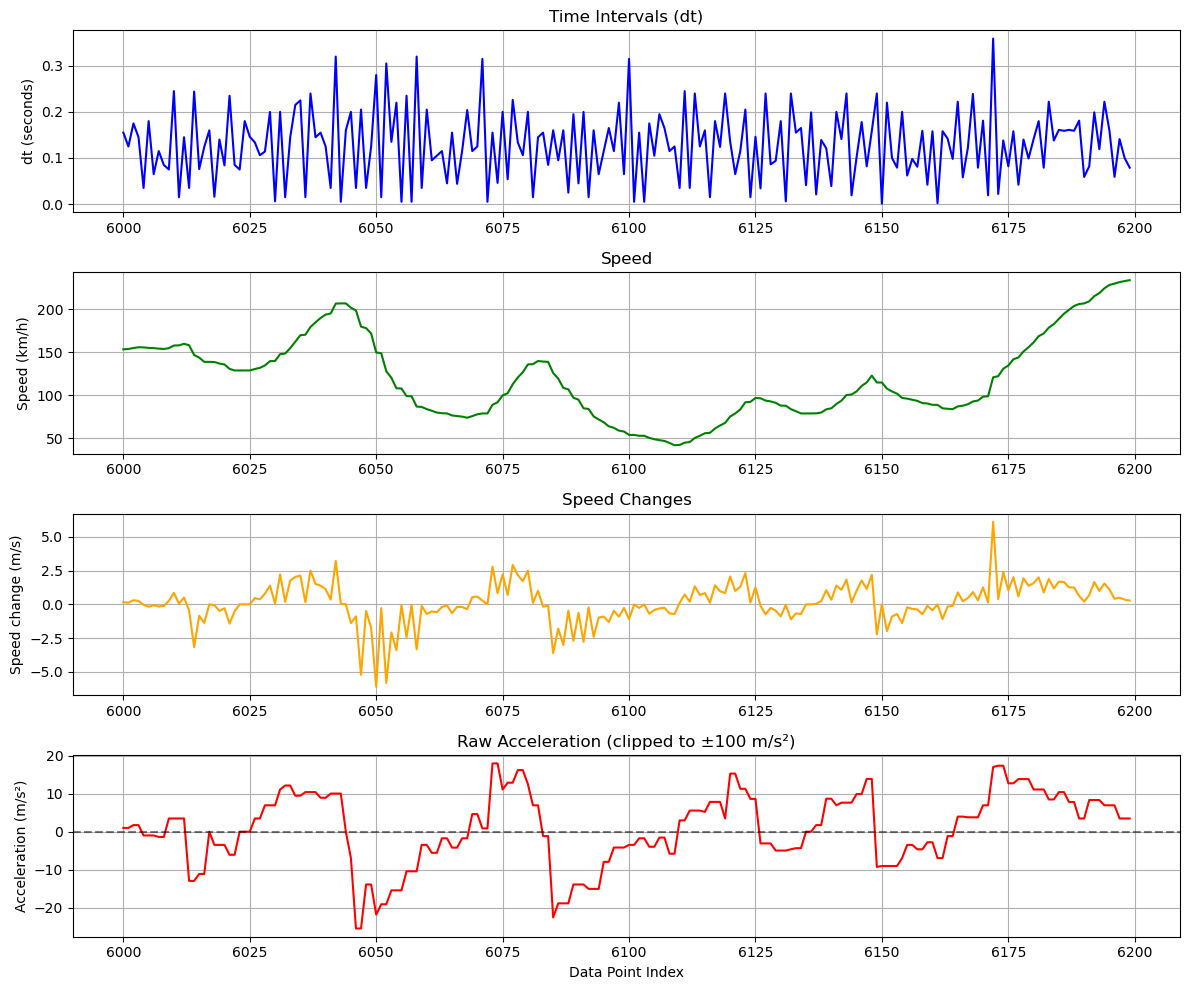

In [63]:
plot_debug_data(ver, dt, speed_ms, raw_accel, start_idx=6000, end_idx=6200)

In [28]:
df_realistic = calculate_realistic_gforce(ver, min_dt=0.005)

In [29]:
print("Realistic G-force results:")
moving_data = df_realistic[df_realistic['Speed'] > 5]
print(f"Max acceleration: +{moving_data['g_force_realistic'].max():.2f}g")
print(f"Max braking: {moving_data['g_force_realistic'].min():.2f}g")
print(f"Very smooth - Max accel: +{moving_data['g_force_very_smooth'].max():.2f}g")
print(f"Very smooth - Max braking: {moving_data['g_force_very_smooth'].min():.2f}g")

Realistic G-force results:
Max acceleration: +3.34g
Max braking: -4.13g
Very smooth - Max accel: +30.99g
Very smooth - Max braking: -42.68g


=== FINAL F1 G-FORCE ANALYSIS ===
Max acceleration: +3.34g
Max braking: -4.13g
Average magnitude: 0.89g


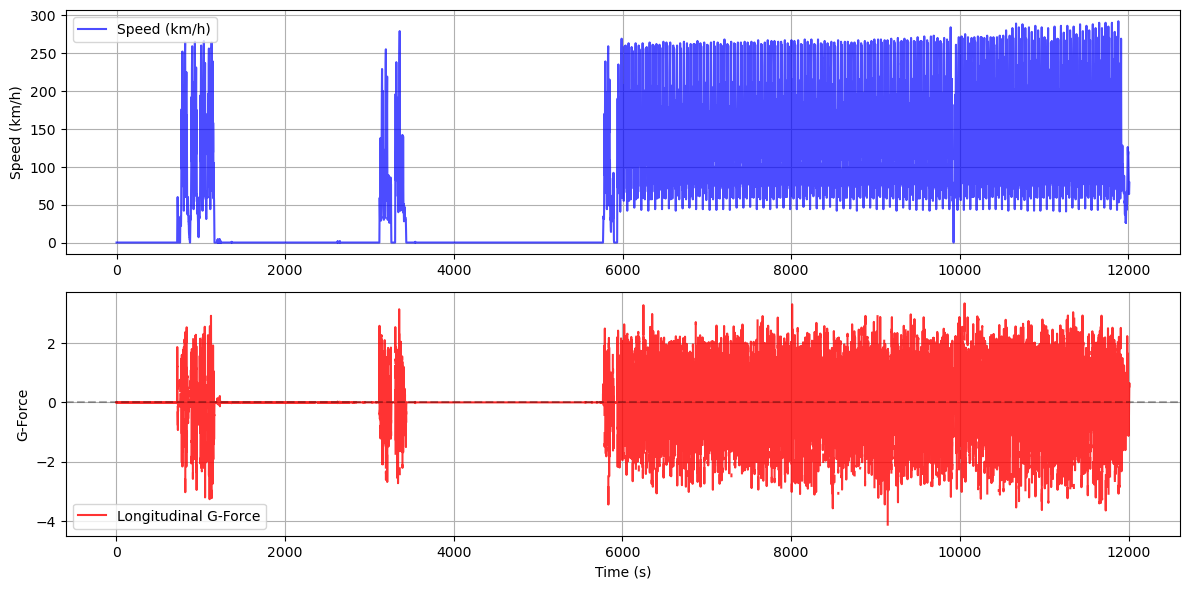

In [30]:
# Use the realistic G-force calculation
df_final = calculate_realistic_gforce(ver, min_dt=0.005)

# Analyze the realistic results
moving_data = df_final[df_final['Speed'] > 5]

print("=== FINAL F1 G-FORCE ANALYSIS ===")
print(f"Max acceleration: +{moving_data['g_force_realistic'].max():.2f}g")
print(f"Max braking: {moving_data['g_force_realistic'].min():.2f}g")
print(f"Average magnitude: {moving_data['g_force_realistic'].abs().mean():.2f}g")

# Plot the realistic G-forces
plt.figure(figsize=(12, 6))
time_seconds = pd.to_timedelta(df_final['Time']).dt.total_seconds()

plt.subplot(2, 1, 1)
plt.plot(time_seconds, df_final['Speed'], 'b-', alpha=0.7, label='Speed (km/h)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_seconds, df_final['g_force_realistic'], 'r-', alpha=0.8, label='Longitudinal G-Force')
plt.ylabel('G-Force')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
df_with_lateral = calculate_lateral_gforce(ver, method='curvature')

In [54]:
analyze_lateral_gforce(df_with_lateral)

=== LATERAL G-FORCE ANALYSIS ===

📊 Curvature-based Lateral G-Forces (Improved):
   Max lateral G-force: 3.27g
   95th percentile: 1.58g
   Average lateral G-force: 0.44g
   Median lateral G-force: 0.22g

📊 Centripetal Acceleration Method:
   Max lateral G-force: 6.00g
   95th percentile: 6.00g
   Average lateral G-force: 2.27g
   Median lateral G-force: 1.83g

🏁 High-G Cornering Events (>2g): 865 points
   Speeds during high-G: 44 - 264 km/h

🔍 Data Quality:
   Valid curvature calculations: 49348/52263 (94.4%)
   Valid centripetal calculations: 20168/52263 (38.6%)


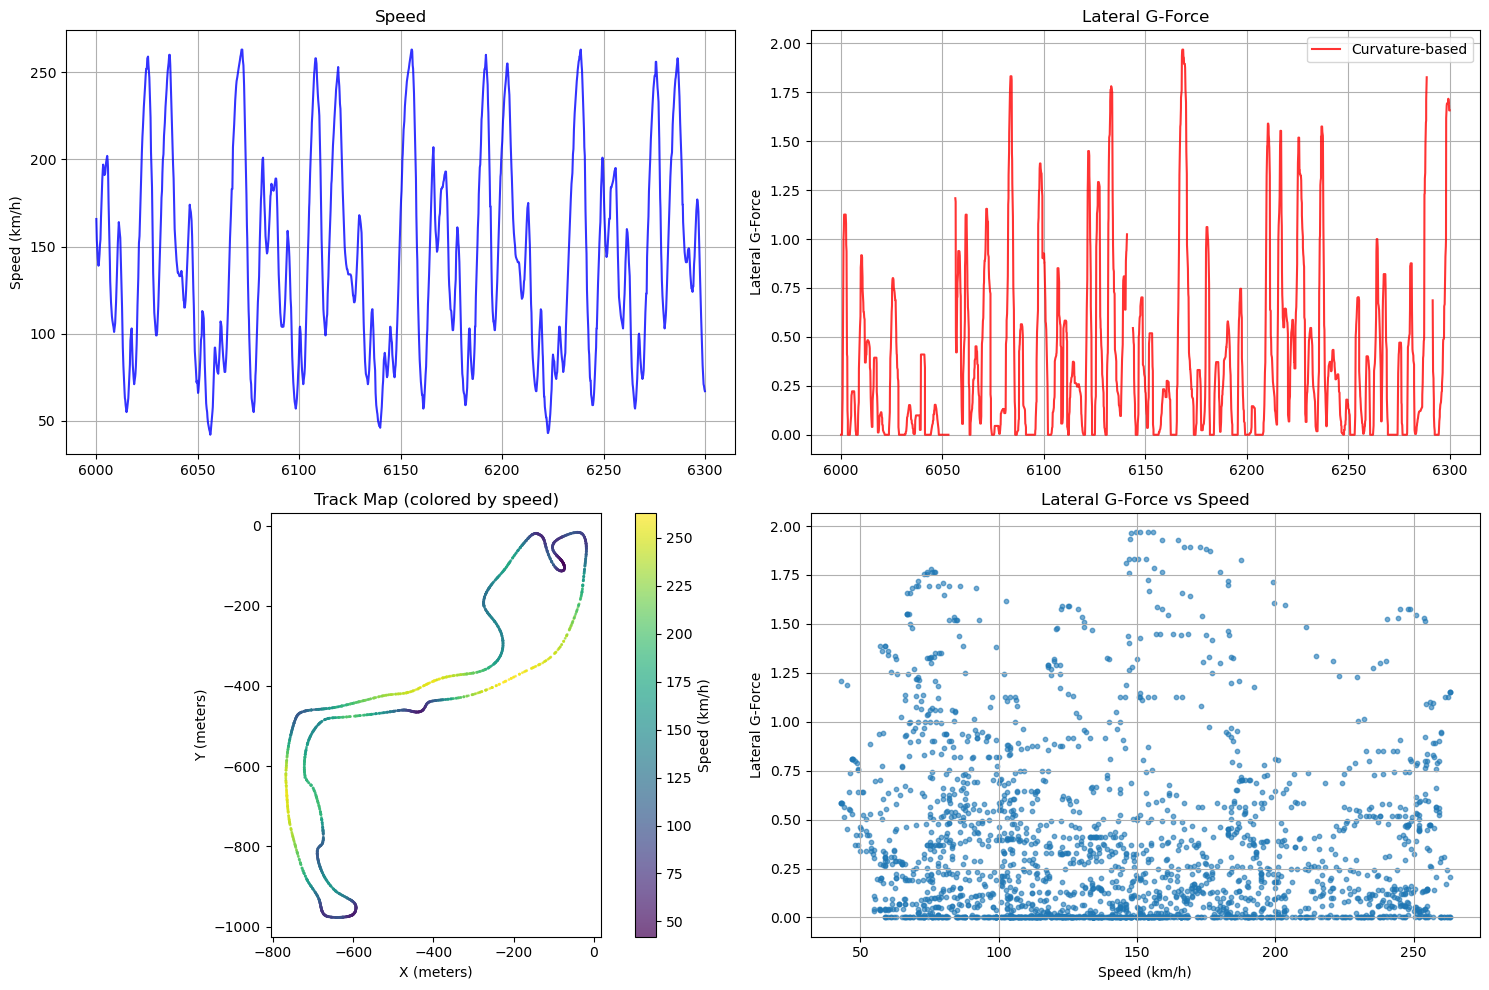

In [55]:
plot_lateral_gforce(df_with_lateral, start_time=6000, duration=300)

=== DETAILED LATERAL G-FORCE ANALYSIS ===
Total cornering time: 7477 points

G-Forces by speed range:
Low speed (<100 km/h): avg 0.45g, max 3.18g
Medium speed (100-200): avg 0.44g, max 3.27g
High speed (>200 km/h): avg 0.43g, max 2.62g


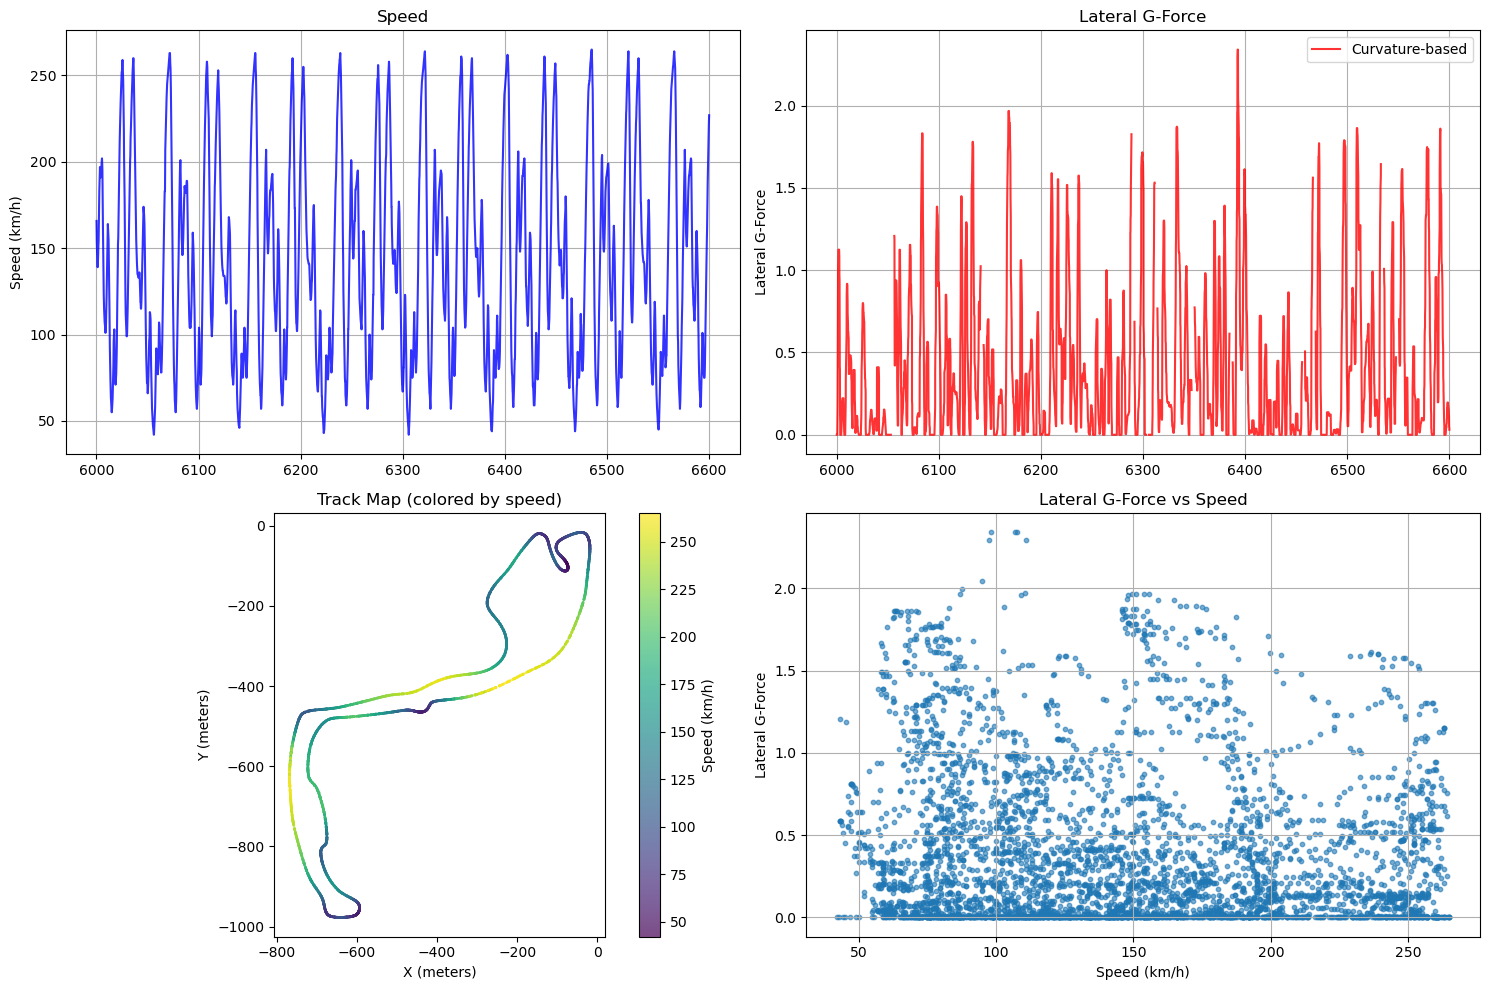

In [56]:
# Let's see the distribution and remove the 8g clipping
def analyze_detailed_lateral(df):
    moving_data = df[df['Speed'] > 20]
    
    print("=== DETAILED LATERAL G-FORCE ANALYSIS ===")
    print(f"Total cornering time: {len(moving_data[moving_data['g_force_lateral_curvature'] > 1])} points")
    
    # Speed bins
    low_speed = moving_data[moving_data['Speed'] < 100]
    med_speed = moving_data[(moving_data['Speed'] >= 100) & (moving_data['Speed'] < 200)]
    high_speed = moving_data[moving_data['Speed'] >= 200]
    
    print(f"\nG-Forces by speed range:")
    print(f"Low speed (<100 km/h): avg {low_speed['g_force_lateral_curvature'].mean():.2f}g, max {low_speed['g_force_lateral_curvature'].max():.2f}g")
    print(f"Medium speed (100-200): avg {med_speed['g_force_lateral_curvature'].mean():.2f}g, max {med_speed['g_force_lateral_curvature'].max():.2f}g")
    print(f"High speed (>200 km/h): avg {high_speed['g_force_lateral_curvature'].mean():.2f}g, max {high_speed['g_force_lateral_curvature'].max():.2f}g")
    
    # Find the most extreme cornering
    extreme_corners = moving_data[moving_data['g_force_lateral_curvature'] >= 7.5]
    if len(extreme_corners) > 0:
        print(f"\nExtreme cornering events (≥7.5g): {len(extreme_corners)} points")
        print(f"Speeds during extreme cornering: {extreme_corners['Speed'].describe()}")

# Run detailed analysis
analyze_detailed_lateral(df_with_lateral)

# Let's also plot a section with high cornering activity
plot_lateral_gforce(df_with_lateral, start_time=6000, duration=600)  # 10 minutes

=== TRACK CHARACTERISTICS ===
Hairpins/Tight corners (<80 km/h, >4g): 0 points
Medium corners (80-150 km/h, >3g): 1 points
High-speed corners (>150 km/h, >2g): 375 points

Racing Intensity:
Total racing time: ~113.2 minutes
Time spent cornering: ~16.2 minutes (14.3%)


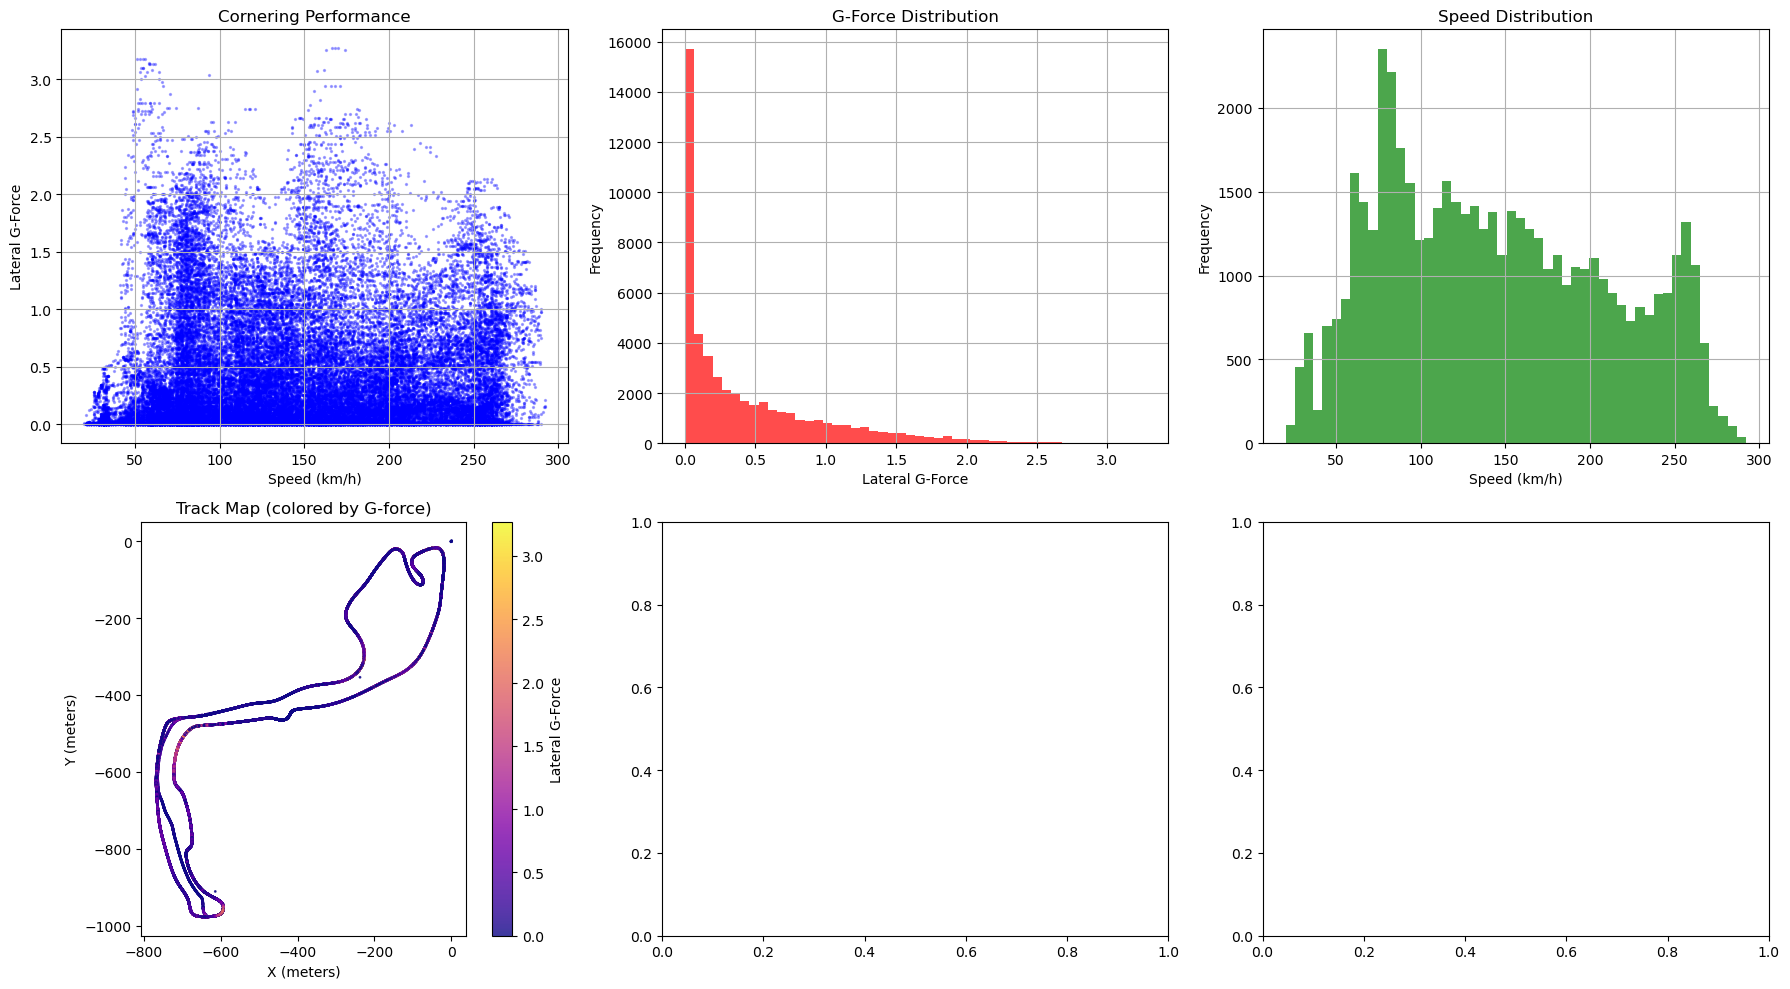

In [57]:
# Let's analyze the track characteristics
def analyze_track_characteristics(df):
    moving_data = df[df['Speed'] > 20]
    
    print("=== TRACK CHARACTERISTICS ===")
    
    # Corner types based on speed and G-force
    hairpins = moving_data[(moving_data['Speed'] < 80) & (moving_data['g_force_lateral_curvature'] > 4)]
    medium_corners = moving_data[(moving_data['Speed'] >= 80) & (moving_data['Speed'] < 150) & 
                                 (moving_data['g_force_lateral_curvature'] > 3)]
    high_speed_corners = moving_data[(moving_data['Speed'] >= 150) & (moving_data['g_force_lateral_curvature'] > 2)]
    
    print(f"Hairpins/Tight corners (<80 km/h, >4g): {len(hairpins)} points")
    print(f"Medium corners (80-150 km/h, >3g): {len(medium_corners)} points") 
    print(f"High-speed corners (>150 km/h, >2g): {len(high_speed_corners)} points")
    
    # Racing intensity
    total_time = len(moving_data) * 0.13  # Approximate seconds (avg dt = 0.13)
    corner_time = len(moving_data[moving_data['g_force_lateral_curvature'] > 1]) * 0.13
    
    print(f"\nRacing Intensity:")
    print(f"Total racing time: ~{total_time/60:.1f} minutes")
    print(f"Time spent cornering: ~{corner_time/60:.1f} minutes ({corner_time/total_time*100:.1f}%)")

# Run track analysis
analyze_track_characteristics(df_with_lateral)

# Create a comprehensive performance plot
def plot_performance_analysis(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    moving_data = df[df['Speed'] > 20]
    
    # G-force vs Speed scatter
    axes[0,0].scatter(moving_data['Speed'], moving_data['g_force_lateral_curvature'], 
                     alpha=0.3, s=2, c='blue')
    axes[0,0].set_xlabel('Speed (km/h)')
    axes[0,0].set_ylabel('Lateral G-Force')
    axes[0,0].set_title('Cornering Performance')
    axes[0,0].grid(True)
    
    # G-force histogram
    axes[0,1].hist(moving_data['g_force_lateral_curvature'], bins=50, alpha=0.7, color='red')
    axes[0,1].set_xlabel('Lateral G-Force')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('G-Force Distribution')
    axes[0,1].grid(True)
    
    # Speed histogram
    axes[0,2].hist(moving_data['Speed'], bins=50, alpha=0.7, color='green')
    axes[0,2].set_xlabel('Speed (km/h)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Speed Distribution')
    axes[0,2].grid(True)
    
    # Track map colored by G-force
    x_m = moving_data['X'] / 10
    y_m = moving_data['Y'] / 10
    scatter = axes[1,0].scatter(x_m, y_m, c=moving_data['g_force_lateral_curvature'], 
                               cmap='plasma', s=1, alpha=0.8)
    axes[1,0].set_title('Track Map (colored by G-force)')
    axes[1,0].set_xlabel('X (meters)')
    axes[1,0].set_ylabel('Y (meters)')
    axes[1,0].set_aspect('equal')
    plt.colorbar(scatter, ax=axes[1,0], label='Lateral G-Force')
    
    # Combined longitudinal + lateral G-forces
    if 'g_force_realistic' in df.columns:
        time_seconds = pd.to_timedelta(moving_data['Time']).dt.total_seconds()
        axes[1,1].plot(time_seconds, moving_data['g_force_realistic'], 'b-', alpha=0.7, label='Longitudinal')
        axes[1,1].plot(time_seconds, moving_data['g_force_lateral_curvature'], 'r-', alpha=0.7, label='Lateral')
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('G-Force')
        axes[1,1].set_title('Combined G-Forces vs Time')
        axes[1,1].legend()
        axes[1,1].grid(True)
    
    # G-force polar plot (magnitude and direction)
    if 'g_force_realistic' in df.columns:
        # Calculate total G-force vector
        total_g = np.sqrt(moving_data['g_force_realistic']**2 + moving_data['g_force_lateral_curvature']**2)
        angles = np.arctan2(moving_data['g_force_lateral_curvature'], moving_data['g_force_realistic'])
        
        # Subsample for clarity
        subsample = moving_data.iloc[::100]  
        total_g_sub = np.sqrt(subsample['g_force_realistic']**2 + subsample['g_force_lateral_curvature']**2)
        angles_sub = np.arctan2(subsample['g_force_lateral_curvature'], subsample['g_force_realistic'])
        
        axes[1,2].scatter(subsample['g_force_realistic'], subsample['g_force_lateral_curvature'], 
                         c=subsample['Speed'], cmap='viridis', alpha=0.6, s=10)
        axes[1,2].set_xlabel('Longitudinal G-Force')
        axes[1,2].set_ylabel('Lateral G-Force')
        axes[1,2].set_title('G-Force Vector Plot')
        axes[1,2].grid(True)
        axes[1,2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        axes[1,2].axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create comprehensive analysis
plot_performance_analysis(df_with_lateral)

=== LATERAL G-FORCE ANALYSIS ===

📊 Curvature-based Lateral G-Forces (Improved):
   Max lateral G-force: 3.27g
   95th percentile: 1.53g
   Average lateral G-force: 0.43g
   Median lateral G-force: 0.21g

📊 Centripetal Acceleration Method:
   Max lateral G-force: 5.50g
   95th percentile: 5.50g
   Average lateral G-force: 2.23g
   Median lateral G-force: 1.83g

🏁 High-G Cornering Events (>2g): 730 points
   Speeds during high-G: 45 - 264 km/h

🔍 Data Quality:
   Valid curvature calculations: 48539/52263 (92.9%)
   Valid centripetal calculations: 20168/52263 (38.6%)

=== METHOD COMPARISON ===
Curvature method vs Centripetal method correlation:
Correlation coefficient: 0.746


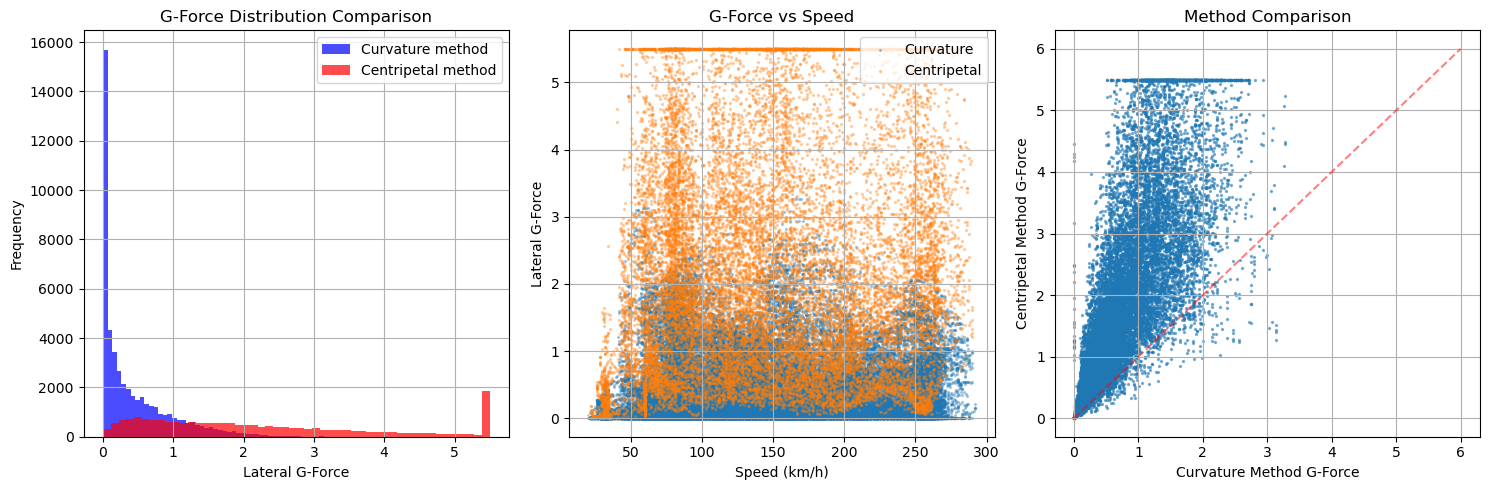

In [60]:
# Recalculate with much more aggressive filtering and realistic limits
df_realistic_lateral = calculate_lateral_gforce(ver, method='curvature', max_realistic_g=5.5)

# Analyze the improved results
analyze_lateral_gforce(df_realistic_lateral)

# Compare the methods
print("\n=== METHOD COMPARISON ===")
moving_data = df_realistic_lateral[df_realistic_lateral['Speed'] > 20]

if 'g_force_lateral_curvature' in df_realistic_lateral.columns and 'g_force_lateral_centripetal' in df_realistic_lateral.columns:
    print("Curvature method vs Centripetal method correlation:")
    correlation = moving_data['g_force_lateral_curvature'].corr(moving_data['g_force_lateral_centripetal'])
    print(f"Correlation coefficient: {correlation:.3f}")

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(moving_data['g_force_lateral_curvature'].dropna(), bins=50, alpha=0.7, color='blue', label='Curvature method')
if 'g_force_lateral_centripetal' in df_realistic_lateral.columns:
    plt.hist(moving_data['g_force_lateral_centripetal'].dropna(), bins=50, alpha=0.7, color='red', label='Centripetal method')
plt.xlabel('Lateral G-Force')
plt.ylabel('Frequency')
plt.title('G-Force Distribution Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(moving_data['Speed'], moving_data['g_force_lateral_curvature'], alpha=0.3, s=2, label='Curvature')
if 'g_force_lateral_centripetal' in df_realistic_lateral.columns:
    plt.scatter(moving_data['Speed'], moving_data['g_force_lateral_centripetal'], alpha=0.3, s=2, label='Centripetal')
plt.xlabel('Speed (km/h)')
plt.ylabel('Lateral G-Force')
plt.title('G-Force vs Speed')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
if 'g_force_lateral_centripetal' in df_realistic_lateral.columns:
    plt.scatter(moving_data['g_force_lateral_curvature'], moving_data['g_force_lateral_centripetal'], alpha=0.5, s=2)
    plt.xlabel('Curvature Method G-Force')
    plt.ylabel('Centripetal Method G-Force')
    plt.title('Method Comparison')
    plt.plot([0, 6], [0, 6], 'r--', alpha=0.5)  # Perfect correlation line
    plt.grid(True)

plt.tight_layout()
plt.show()

In [61]:
# Let's create a hybrid approach using the best of both methods
def create_final_lateral_gforce(df):
    """
    Create final lateral G-force using the most reliable method
    """
    df_final = df.copy()
    
    # Use curvature method as primary (more reliable)
    primary_gforce = df_final['g_force_lateral_curvature'].copy()
    
    # Use centripetal method to fill gaps where curvature method failed
    if 'g_force_lateral_centripetal' in df_final.columns:
        # Where curvature method is NaN, use centripetal method (but cap it)
        centripetal_capped = np.clip(df_final['g_force_lateral_centripetal'], 0, 4.0)  # Cap at 4g
        primary_gforce = primary_gforce.fillna(centripetal_capped)
    
    # Final smoothing
    df_final['g_force_lateral_final'] = primary_gforce.rolling(window=5, center=True).mean()
    
    return df_final

# Create final version
df_final_lateral = create_final_lateral_gforce(df_realistic_lateral)

# Analyze final results
moving_data = df_final_lateral[df_final_lateral['Speed'] > 20]
print("=== FINAL LATERAL G-FORCE RESULTS ===")
print(f"Max lateral G-force: {moving_data['g_force_lateral_final'].max():.2f}g")
print(f"95th percentile: {moving_data['g_force_lateral_final'].quantile(0.95):.2f}g")
print(f"Average during cornering (>1g): {moving_data[moving_data['g_force_lateral_final'] > 1]['g_force_lateral_final'].mean():.2f}g")
print(f"High-G events (>2.5g): {len(moving_data[moving_data['g_force_lateral_final'] > 2.5])} points")

# Create comprehensive F1 performance summary
print("\n=== COMPLETE F1 PERFORMANCE SUMMARY ===")
if 'g_force_realistic' in df_final_lateral.columns:
    print("Longitudinal G-Forces:")
    print(f"  Max acceleration: +{moving_data['g_force_realistic'].max():.2f}g")
    print(f"  Max braking: {moving_data['g_force_realistic'].min():.2f}g")

print("Lateral G-Forces:")
print(f"  Max cornering: {moving_data['g_force_lateral_final'].max():.2f}g")
print(f"  Average cornering: {moving_data['g_force_lateral_final'].mean():.2f}g")

print("Speed Performance:")
print(f"  Top speed: {df_final_lateral['Speed'].max():.0f} km/h")
print(f"  Average racing speed: {moving_data['Speed'].mean():.0f} km/h")

# Calculate combined G-force
if 'g_force_realistic' in df_final_lateral.columns:
    combined_g = np.sqrt(moving_data['g_force_realistic']**2 + moving_data['g_force_lateral_final']**2)
    print(f"Combined G-Forces:")
    print(f"  Max total G-force: {combined_g.max():.2f}g")
    print(f"  Average total G-force: {combined_g.mean():.2f}g")

=== FINAL LATERAL G-FORCE RESULTS ===
Max lateral G-force: 4.00g
95th percentile: 1.99g
Average during cornering (>1g): 1.86g
High-G events (>2.5g): 1699 points

=== COMPLETE F1 PERFORMANCE SUMMARY ===
Lateral G-Forces:
  Max cornering: 4.00g
  Average cornering: 0.55g
Speed Performance:
  Top speed: 292 km/h
  Average racing speed: 144 km/h


=== MONACO F1 PERFORMANCE ANALYSIS ===

🏎️ Monaco Corner Analysis:
Hairpin/Ultra-tight (<60 km/h): 4166 points, avg G: 0.41g
Typical Monaco corners (60-120): 17535 points, avg G: 0.62g
Medium corners (120-200): 18081 points, avg G: 0.55g
Straights (>200 km/h): 12481 points, avg G: 0.48g

🔄 Grand Hotel Hairpin area (<50 km/h):
   Max G-force: 4.00g
   Average G-force: 0.27g

🏊 Swimming Pool/Chicane areas (80-140 km/h, >1.5g):
   Points: 1466
   Average G-force: 2.45g

🚇 Tunnel section (>250 km/h):
   Max speed: 292 km/h
   Points at high speed: 4253


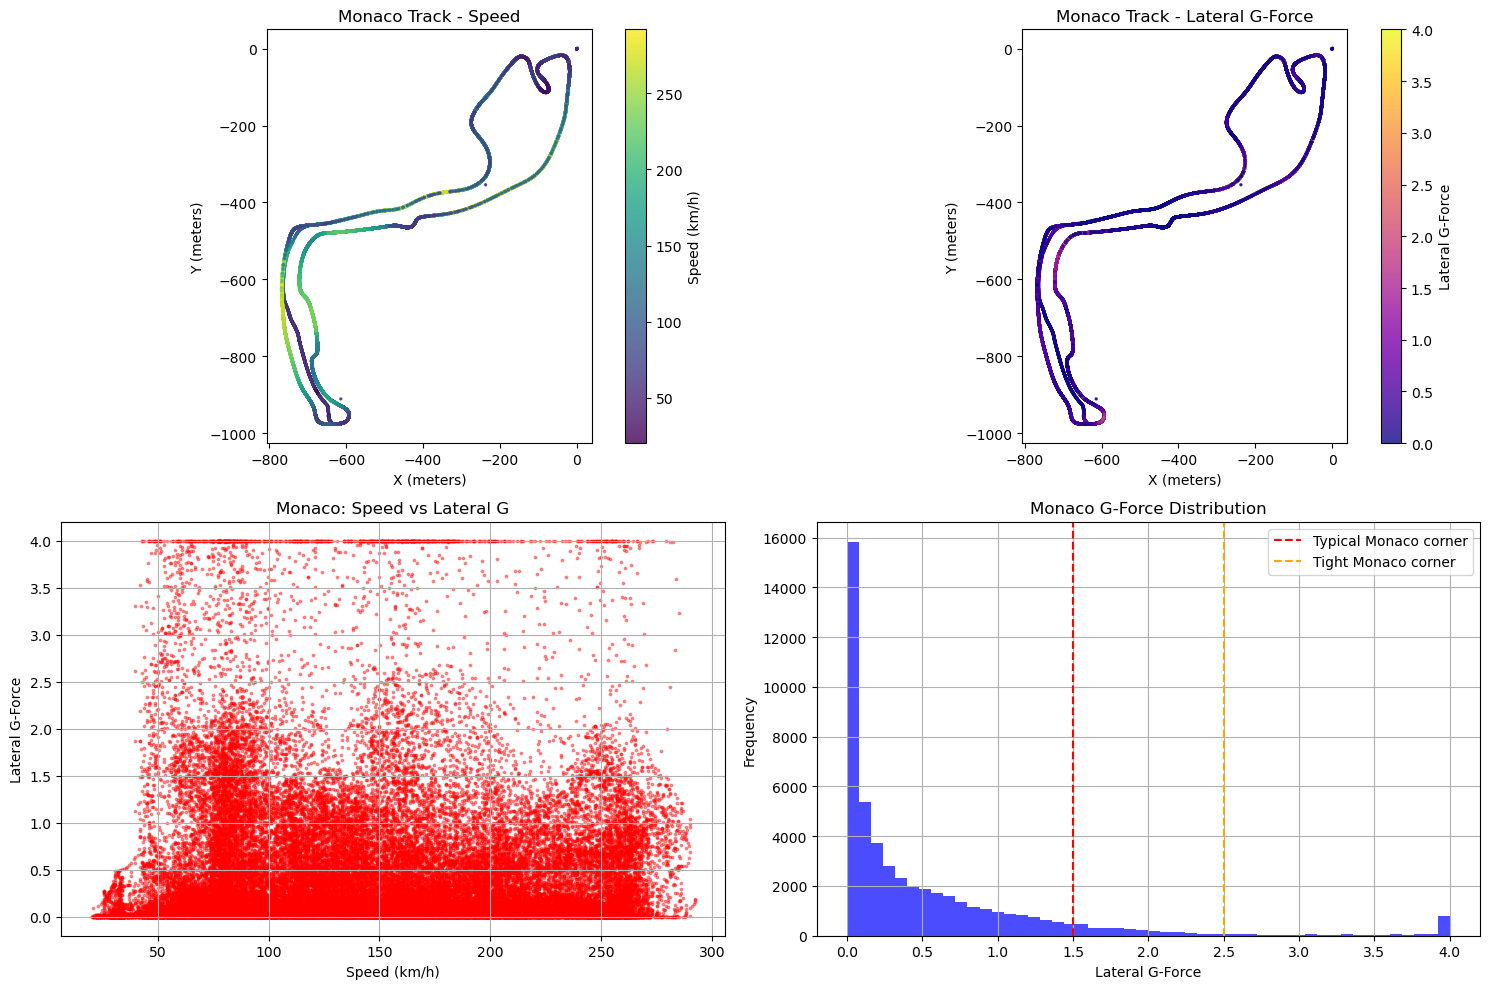

In [62]:
# Monaco-specific corner analysis
def analyze_monaco_performance(df):
    moving_data = df[df['Speed'] > 20]
    
    print("=== MONACO F1 PERFORMANCE ANALYSIS ===\n")
    
    # Monaco corner categories
    hairpin_speed = moving_data[moving_data['Speed'] < 60]  # Hairpin, Rascasse
    low_speed = moving_data[(moving_data['Speed'] >= 60) & (moving_data['Speed'] < 120)]  # Most Monaco corners
    medium_speed = moving_data[(moving_data['Speed'] >= 120) & (moving_data['Speed'] < 200)]  # Tunnel exit, Portier
    high_speed = moving_data[moving_data['Speed'] >= 200]  # Tunnel, main straight
    
    print("🏎️ Monaco Corner Analysis:")
    print(f"Hairpin/Ultra-tight (<60 km/h): {len(hairpin_speed)} points, avg G: {hairpin_speed['g_force_lateral_final'].mean():.2f}g")
    print(f"Typical Monaco corners (60-120): {len(low_speed)} points, avg G: {low_speed['g_force_lateral_final'].mean():.2f}g") 
    print(f"Medium corners (120-200): {len(medium_speed)} points, avg G: {medium_speed['g_force_lateral_final'].mean():.2f}g")
    print(f"Straights (>200 km/h): {len(high_speed)} points, avg G: {high_speed['g_force_lateral_final'].mean():.2f}g")
    
    # Famous Monaco corners analysis
    extreme_slow = moving_data[moving_data['Speed'] < 50]  # Likely hairpin
    if len(extreme_slow) > 0:
        print(f"\n🔄 Grand Hotel Hairpin area (<50 km/h):")
        print(f"   Max G-force: {extreme_slow['g_force_lateral_final'].max():.2f}g")
        print(f"   Average G-force: {extreme_slow['g_force_lateral_final'].mean():.2f}g")
    
    # Swimming pool chicane (rapid direction changes)
    medium_g_events = moving_data[(moving_data['g_force_lateral_final'] > 1.5) & 
                                  (moving_data['Speed'] > 80) & (moving_data['Speed'] < 140)]
    if len(medium_g_events) > 0:
        print(f"\n🏊 Swimming Pool/Chicane areas (80-140 km/h, >1.5g):")
        print(f"   Points: {len(medium_g_events)}")
        print(f"   Average G-force: {medium_g_events['g_force_lateral_final'].mean():.2f}g")
    
    # Tunnel section analysis
    tunnel_speed = moving_data[moving_data['Speed'] > 250]
    if len(tunnel_speed) > 0:
        print(f"\n🚇 Tunnel section (>250 km/h):")
        print(f"   Max speed: {tunnel_speed['Speed'].max():.0f} km/h")
        print(f"   Points at high speed: {len(tunnel_speed)}")

# Monaco track map analysis
def plot_monaco_track_analysis(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    moving_data = df[df['Speed'] > 20]
    x_m = moving_data['X'] / 10
    y_m = moving_data['Y'] / 10
    
    # Track map with speed
    scatter1 = axes[0,0].scatter(x_m, y_m, c=moving_data['Speed'], cmap='viridis', s=2, alpha=0.8)
    axes[0,0].set_title('Monaco Track - Speed')
    axes[0,0].set_xlabel('X (meters)')
    axes[0,0].set_ylabel('Y (meters)')
    axes[0,0].set_aspect('equal')
    plt.colorbar(scatter1, ax=axes[0,0], label='Speed (km/h)')
    
    # Track map with G-force
    scatter2 = axes[0,1].scatter(x_m, y_m, c=moving_data['g_force_lateral_final'], 
                                cmap='plasma', s=2, alpha=0.8, vmax=4)
    axes[0,1].set_title('Monaco Track - Lateral G-Force')
    axes[0,1].set_xlabel('X (meters)')
    axes[0,1].set_ylabel('Y (meters)')
    axes[0,1].set_aspect('equal')
    plt.colorbar(scatter2, ax=axes[0,1], label='Lateral G-Force')
    
    # Speed vs G-force (Monaco characteristic)
    axes[1,0].scatter(moving_data['Speed'], moving_data['g_force_lateral_final'], 
                     alpha=0.4, s=3, c='red')
    axes[1,0].set_xlabel('Speed (km/h)')
    axes[1,0].set_ylabel('Lateral G-Force')
    axes[1,0].set_title('Monaco: Speed vs Lateral G')
    axes[1,0].grid(True)
    
    # G-force histogram with Monaco ranges
    axes[1,1].hist(moving_data['g_force_lateral_final'], bins=50, alpha=0.7, color='blue')
    axes[1,1].axvline(x=1.5, color='red', linestyle='--', label='Typical Monaco corner')
    axes[1,1].axvline(x=2.5, color='orange', linestyle='--', label='Tight Monaco corner')
    axes[1,1].set_xlabel('Lateral G-Force')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Monaco G-Force Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Run Monaco analysis
analyze_monaco_performance(df_final_lateral)
plot_monaco_track_analysis(df_final_lateral)

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_combined_gforce(df, longitudinal_col=None, lateral_col=None):
    """
    Calculate combined G-force from lateral and longitudinal components
    
    Parameters:
    df: DataFrame with G-force data
    longitudinal_col: Column name for longitudinal G-force (auto-detect if None)
    lateral_col: Column name for lateral G-force (auto-detect if None)
    
    Returns:
    DataFrame with combined G-force calculations
    """
    df_combined = df.copy()
    
    # Auto-detect G-force columns if not specified
    gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
    
    if longitudinal_col is None:
        # Look for longitudinal G-force columns
        long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
        if long_candidates:
            longitudinal_col = long_candidates[0]
        else:
            print("⚠️ No longitudinal G-force column found. Available columns:")
            print(gforce_cols)
            return df_combined
    
    if lateral_col is None:
        # Look for lateral G-force columns
        lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
        if lat_candidates:
            lateral_col = lat_candidates[0]
        else:
            print("⚠️ No lateral G-force column found. Available columns:")
            print(gforce_cols)
            return df_combined
    
    print(f"Using longitudinal G-force: {longitudinal_col}")
    print(f"Using lateral G-force: {lateral_col}")
    
    # Check if columns exist
    if longitudinal_col not in df.columns:
        print(f"❌ Column '{longitudinal_col}' not found in DataFrame")
        return df_combined
    
    if lateral_col not in df.columns:
        print(f"❌ Column '{lateral_col}' not found in DataFrame")
        return df_combined
    
    # Calculate total G-force magnitude using Pythagorean theorem
    # Total G = √(longitudinal² + lateral²)
    df_combined['g_force_total'] = np.sqrt(df_combined[longitudinal_col]**2 + 
                                          df_combined[lateral_col]**2)
    
    # Calculate G-force direction (angle in degrees)
    # 0° = pure longitudinal, 90° = pure lateral
    df_combined['g_force_angle'] = np.degrees(np.arctan2(np.abs(df_combined[lateral_col]), 
                                                         np.abs(df_combined[longitudinal_col])))
    
    # Create G-force categories based on dominant component
    conditions = [
        (np.abs(df_combined[longitudinal_col]) > np.abs(df_combined[lateral_col]) * 2),  # Longitudinal dominant
        (np.abs(df_combined[lateral_col]) > np.abs(df_combined[longitudinal_col]) * 2),   # Lateral dominant
        True  # Mixed/balanced
    ]
    choices = ['Longitudinal', 'Lateral', 'Mixed']
    df_combined['g_force_type'] = np.select(conditions, choices)
    
    # Create intensity categories
    g_conditions = [
        (df_combined['g_force_total'] < 1.0),
        (df_combined['g_force_total'] < 2.0),
        (df_combined['g_force_total'] < 3.0),
        (df_combined['g_force_total'] < 4.0),
        True
    ]
    g_choices = ['Light (<1g)', 'Moderate (1-2g)', 'High (2-3g)', 'Extreme (3-4g)', 'Maximum (>4g)']
    df_combined['g_force_intensity'] = np.select(g_conditions, g_choices)
    
    return df_combined

def analyze_combined_gforce(df, longitudinal_col=None, lateral_col=None):
    """
    Analyze combined G-force performance with auto-detection
    """
    # Auto-detect columns if not provided
    if longitudinal_col is None or lateral_col is None:
        gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
        
        if longitudinal_col is None:
            long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
            longitudinal_col = long_candidates[0] if long_candidates else None
            
        if lateral_col is None:
            lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
            lateral_col = lat_candidates[0] if lat_candidates else None
    
    if longitudinal_col is None or lateral_col is None:
        print("❌ Could not find both longitudinal and lateral G-force columns")
        print("Available G-force columns:", [col for col in df.columns if 'g_force' in col.lower()])
        return
    
    moving_data = df[df['Speed'] > 20]
    
    print("=== COMBINED G-FORCE ANALYSIS ===\n")
    
    # Overall statistics
    print("📊 Total G-Force Statistics:")
    print(f"   Maximum total G-force: {moving_data['g_force_total'].max():.2f}g")
    print(f"   95th percentile: {moving_data['g_force_total'].quantile(0.95):.2f}g")
    print(f"   Average total G-force: {moving_data['g_force_total'].mean():.2f}g")
    print(f"   Median total G-force: {moving_data['g_force_total'].median():.2f}g")
    
    # Component breakdown
    max_long = moving_data[longitudinal_col].max()
    min_long = moving_data[longitudinal_col].min()
    max_lat = moving_data[lateral_col].max()
    
    print(f"\n🔍 Component Analysis:")
    print(f"   Max longitudinal: +{max_long:.2f}g / {min_long:.2f}g")
    print(f"   Max lateral: ±{max_lat:.2f}g")
    print(f"   Theoretical max if combined: {np.sqrt(max(abs(max_long), abs(min_long))**2 + max_lat**2):.2f}g")
    
    # G-force type distribution
    print(f"\n⚡ G-Force Type Distribution:")
    type_counts = moving_data['g_force_type'].value_counts()
    total_points = len(moving_data)
    for gforce_type, count in type_counts.items():
        print(f"   {gforce_type}: {count} points ({count/total_points*100:.1f}%)")
    
    # Intensity distribution
    print(f"\n🌡️ G-Force Intensity Distribution:")
    intensity_counts = moving_data['g_force_intensity'].value_counts()
    for intensity, count in intensity_counts.items():
        print(f"   {intensity}: {count} points ({count/total_points*100:.1f}%)")
    
    # Extreme G-force events
    extreme_events = moving_data[moving_data['g_force_total'] > 4.0]
    if len(extreme_events) > 0:
        print(f"\n🔥 Extreme G-Force Events (>4g): {len(extreme_events)} points")
        print(f"   Speed range during extreme G: {extreme_events['Speed'].min():.0f} - {extreme_events['Speed'].max():.0f} km/h")
        print(f"   Average speed: {extreme_events['Speed'].mean():.0f} km/h")
        print(f"   Max total G-force: {extreme_events['g_force_total'].max():.2f}g")
    
    # Peak combined events (find when both lat and long are high)
    peak_combined = moving_data[(np.abs(moving_data[longitudinal_col]) > 2.0) & 
                               (moving_data[lateral_col] > 2.0)]
    if len(peak_combined) > 0:
        print(f"\n💥 Peak Combined Events (>2g both directions): {len(peak_combined)} points")
        print(f"   Average total G-force: {peak_combined['g_force_total'].mean():.2f}g")
        print(f"   Max total G-force: {peak_combined['g_force_total'].max():.2f}g")

def plot_combined_gforce_analysis(df, longitudinal_col=None, lateral_col=None):
    """
    Create comprehensive combined G-force visualizations with auto-detection
    """
    # Auto-detect columns if not providedimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_combined_gforce(df, longitudinal_col=None, lateral_col=None):
    """
    Calculate combined G-force from lateral and longitudinal components
    
    Parameters:
    df: DataFrame with G-force data
    longitudinal_col: Column name for longitudinal G-force (auto-detect if None)
    lateral_col: Column name for lateral G-force (auto-detect if None)
    
    Returns:
    DataFrame with combined G-force calculations
    """
    df_combined = df.copy()
    
    # Auto-detect G-force columns if not specified
    gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
    
    if longitudinal_col is None:
        # Look for longitudinal G-force columns
        long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
        if long_candidates:
            longitudinal_col = long_candidates[0]
        else:
            print("⚠️ No longitudinal G-force column found. Available columns:")
            print(gforce_cols)
            return df_combined
    
    if lateral_col is None:
        # Look for lateral G-force columns
        lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
        if lat_candidates:
            lateral_col = lat_candidates[0]
        else:
            print("⚠️ No lateral G-force column found. Available columns:")
            print(gforce_cols)
            return df_combined
    
    print(f"Using longitudinal G-force: {longitudinal_col}")
    print(f"Using lateral G-force: {lateral_col}")
    
    # Check if columns exist
    if longitudinal_col not in df.columns:
        print(f"❌ Column '{longitudinal_col}' not found in DataFrame")
        return df_combined
    
    if lateral_col not in df.columns:
        print(f"❌ Column '{lateral_col}' not found in DataFrame")
        return df_combined
    
    # Calculate total G-force magnitude using Pythagorean theorem
    # Total G = √(longitudinal² + lateral²)
    df_combined['g_force_total'] = np.sqrt(df_combined[longitudinal_col]**2 + 
                                          df_combined[lateral_col]**2)
    
    # Calculate G-force direction (angle in degrees)
    # 0° = pure longitudinal, 90° = pure lateral
    df_combined['g_force_angle'] = np.degrees(np.arctan2(np.abs(df_combined[lateral_col]), 
                                                         np.abs(df_combined[longitudinal_col])))
    
    # Create G-force categories based on dominant component
    conditions = [
        (np.abs(df_combined[longitudinal_col]) > np.abs(df_combined[lateral_col]) * 2),  # Longitudinal dominant
        (np.abs(df_combined[lateral_col]) > np.abs(df_combined[longitudinal_col]) * 2),   # Lateral dominant
        True  # Mixed/balanced
    ]
    choices = ['Longitudinal', 'Lateral', 'Mixed']
    df_combined['g_force_type'] = np.select(conditions, choices)
    
    # Create intensity categories
    g_conditions = [
        (df_combined['g_force_total'] < 1.0),
        (df_combined['g_force_total'] < 2.0),
        (df_combined['g_force_total'] < 3.0),
        (df_combined['g_force_total'] < 4.0),
        True
    ]
    g_choices = ['Light (<1g)', 'Moderate (1-2g)', 'High (2-3g)', 'Extreme (3-4g)', 'Maximum (>4g)']
    df_combined['g_force_intensity'] = np.select(g_conditions, g_choices)
    
    return df_combined

def analyze_combined_gforce(df, longitudinal_col=None, lateral_col=None):
    """
    Analyze combined G-force performance with auto-detection
    """
    # Auto-detect columns if not provided
    if longitudinal_col is None or lateral_col is None:
        gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
        
        if longitudinal_col is None:
            long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
            longitudinal_col = long_candidates[0] if long_candidates else None
            
        if lateral_col is None:
            lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
            lateral_col = lat_candidates[0] if lat_candidates else None
    
    if longitudinal_col is None or lateral_col is None:
        print("❌ Could not find both longitudinal and lateral G-force columns")
        print("Available G-force columns:", [col for col in df.columns if 'g_force' in col.lower()])
        return
    
    moving_data = df[df['Speed'] > 20]
    
    print("=== COMBINED G-FORCE ANALYSIS ===\n")
    
    # Overall statistics
    print("📊 Total G-Force Statistics:")
    print(f"   Maximum total G-force: {moving_data['g_force_total'].max():.2f}g")
    print(f"   95th percentile: {moving_data['g_force_total'].quantile(0.95):.2f}g")
    print(f"   Average total G-force: {moving_data['g_force_total'].mean():.2f}g")
    print(f"   Median total G-force: {moving_data['g_force_total'].median():.2f}g")
    
    # Component breakdown
    max_long = moving_data[longitudinal_col].max()
    min_long = moving_data[longitudinal_col].min()
    max_lat = moving_data[lateral_col].max()
    
    print(f"\n🔍 Component Analysis:")
    print(f"   Max longitudinal: +{max_long:.2f}g / {min_long:.2f}g")
    print(f"   Max lateral: ±{max_lat:.2f}g")
    print(f"   Theoretical max if combined: {np.sqrt(max(abs(max_long), abs(min_long))**2 + max_lat**2):.2f}g")
    
    # G-force type distribution
    print(f"\n⚡ G-Force Type Distribution:")
    type_counts = moving_data['g_force_type'].value_counts()
    total_points = len(moving_data)
    for gforce_type, count in type_counts.items():
        print(f"   {gforce_type}: {count} points ({count/total_points*100:.1f}%)")
    
    # Intensity distribution
    print(f"\n🌡️ G-Force Intensity Distribution:")
    intensity_counts = moving_data['g_force_intensity'].value_counts()
    for intensity, count in intensity_counts.items():
        print(f"   {intensity}: {count} points ({count/total_points*100:.1f}%)")
    
    # Extreme G-force events
    extreme_events = moving_data[moving_data['g_force_total'] > 4.0]
    if len(extreme_events) > 0:
        print(f"\n🔥 Extreme G-Force Events (>4g): {len(extreme_events)} points")
        print(f"   Speed range during extreme G: {extreme_events['Speed'].min():.0f} - {extreme_events['Speed'].max():.0f} km/h")
        print(f"   Average speed: {extreme_events['Speed'].mean():.0f} km/h")
        print(f"   Max total G-force: {extreme_events['g_force_total'].max():.2f}g")
    
    # Peak combined events (find when both lat and long are high)
    peak_combined = moving_data[(np.abs(moving_data[longitudinal_col]) > 2.0) & 
                               (moving_data[lateral_col] > 2.0)]
    if len(peak_combined) > 0:
        print(f"\n💥 Peak Combined Events (>2g both directions): {len(peak_combined)} points")
        print(f"   Average total G-force: {peak_combined['g_force_total'].mean():.2f}g")
        print(f"   Max total G-force: {peak_combined['g_force_total'].max():.2f}g")

def plot_combined_gforce_analysis(df, longitudinal_col=None, lateral_col=None):
    """
    Create comprehensive combined G-force visualizations with auto-detection
    """
    # Auto-detect columns if not provided
    if longitudinal_col is None or lateral_col is None:
        gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
        
        if longitudinal_col is None:
            long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
            longitudinal_col = long_candidates[0] if long_candidates else None
            
        if lateral_col is None:
            lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
            lateral_col = lat_candidates[0] if lat_candidates else None
    
    if longitudinal_col is None or lateral_col is None:
        print("❌ Could not find both longitudinal and lateral G-force columns")
        return
        
    moving_data = df[df['Speed'] > 20]
    time_seconds = pd.to_timedelta(moving_data['Time']).dt.total_seconds()
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. G-force vector plot (polar-style) - with NaN filtering
    valid_mask_vector = ~(np.isnan(moving_data[longitudinal_col]) | np.isnan(moving_data[lateral_col]))
    if valid_mask_vector.sum() > 0:
        valid_data_vector = moving_data[valid_mask_vector]
        axes[0,0].scatter(valid_data_vector[longitudinal_col], valid_data_vector[lateral_col], 
                         c=valid_data_vector['Speed'], cmap='viridis', alpha=0.6, s=10)
    axes[0,0].set_xlabel('Longitudinal G-Force')
    axes[0,0].set_ylabel('Lateral G-Force') 
    axes[0,0].set_title('G-Force Vector Plot\n(colored by speed)')
    axes[0,0].grid(True)
    axes[0,0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0,0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Add G-force magnitude circles
    for g_level in [1, 2, 3, 4, 5]:
        circle_x = np.linspace(-g_level, g_level, 100)
        circle_y_pos = np.sqrt(g_level**2 - circle_x**2)
        circle_y_neg = -circle_y_pos
        axes[0,0].plot(circle_x, circle_y_pos, 'r--', alpha=0.3, linewidth=1)
        axes[0,0].plot(circle_x, circle_y_neg, 'r--', alpha=0.3, linewidth=1)
    
    # 2. Total G-force vs time
    axes[0,1].plot(time_seconds, moving_data['g_force_total'], 'purple', alpha=0.8, linewidth=1)
    axes[0,1].set_xlabel('Time (s)')
    axes[0,1].set_ylabel('Total G-Force')
    axes[0,1].set_title('Total G-Force vs Time')
    axes[0,1].grid(True)
    
    # 3. Total G-force histogram
    axes[0,2].hist(moving_data['g_force_total'], bins=50, alpha=0.7, color='purple')
    axes[0,2].axvline(x=moving_data['g_force_total'].mean(), color='red', linestyle='--', label=f'Mean: {moving_data["g_force_total"].mean():.2f}g')
    axes[0,2].axvline(x=moving_data['g_force_total'].quantile(0.95), color='orange', linestyle='--', label=f'95th: {moving_data["g_force_total"].quantile(0.95):.2f}g')
    axes[0,2].set_xlabel('Total G-Force')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Total G-Force Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True)
    
    # 4. G-force vs Speed - with NaN filtering
    valid_mask_speed = ~(np.isnan(moving_data['Speed']) | np.isnan(moving_data['g_force_total']) | np.isnan(moving_data[lateral_col]))
    if valid_mask_speed.sum() > 0:
        valid_data_speed = moving_data[valid_mask_speed]
        axes[1,0].scatter(valid_data_speed['Speed'], valid_data_speed['g_force_total'], 
                         c=valid_data_speed[lateral_col], cmap='plasma', alpha=0.6, s=5)
    axes[1,0].set_xlabel('Speed (km/h)')
    axes[1,0].set_ylabel('Total G-Force')
    axes[1,0].set_title('Total G-Force vs Speed\n(colored by lateral G)')
    axes[1,0].grid(True)
    
    # 5. Component comparison
    axes[1,1].plot(time_seconds, moving_data[longitudinal_col], 'b-', alpha=0.7, label='Longitudinal', linewidth=1)
    axes[1,1].plot(time_seconds, moving_data[lateral_col], 'r-', alpha=0.7, label='Lateral', linewidth=1)
    axes[1,1].plot(time_seconds, moving_data['g_force_total'], 'purple', alpha=0.8, label='Total', linewidth=1.5)
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].set_ylabel('G-Force')
    axes[1,1].set_title('G-Force Components vs Time')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    # 6. G-force angle distribution
    axes[1,2].hist(moving_data['g_force_angle'], bins=30, alpha=0.7, color='green')
    axes[1,2].set_xlabel('G-Force Angle (degrees)')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].set_title('G-Force Direction Distribution\n(0°=longitudinal, 90°=lateral)')
    axes[1,2].grid(True)
    
    # 7. Track map with total G-force
    x_m = moving_data['X'] / 10
    y_m = moving_data['Y'] / 10
    scatter = axes[2,0].scatter(x_m, y_m, c=moving_data['g_force_total'], 
                               cmap='plasma', s=2, alpha=0.8)
    axes[2,0].set_title('Monaco Track - Total G-Force')
    axes[2,0].set_xlabel('X (meters)')
    axes[2,0].set_ylabel('Y (meters)')
    axes[2,0].set_aspect('equal')
    plt.colorbar(scatter, ax=axes[2,0], label='Total G-Force')
    
    # 8. G-force type pie chart
    type_counts = moving_data['g_force_type'].value_counts()
    axes[2,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[2,1].set_title('G-Force Type Distribution')
    
    # 9. Intensity heatmap (Speed vs Total G) - with NaN filtering
    # Remove NaN values before creating histogram
    valid_mask = ~(np.isnan(moving_data['Speed']) | np.isnan(moving_data['g_force_total']))
    valid_speed = moving_data['Speed'][valid_mask]
    valid_total_g = moving_data['g_force_total'][valid_mask]
    
    if len(valid_speed) > 0 and len(valid_total_g) > 0:
        hist, xedges, yedges = np.histogram2d(valid_speed, valid_total_g, bins=30)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        im = axes[2,2].imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='hot')
        axes[2,2].set_xlabel('Speed (km/h)')
        axes[2,2].set_ylabel('Total G-Force')
        axes[2,2].set_title('G-Force Intensity Heatmap')
        plt.colorbar(im, ax=axes[2,2], label='Frequency')
    else:
        axes[2,2].text(0.5, 0.5, 'No valid data for heatmap', 
                      transform=axes[2,2].transAxes, ha='center', va='center')
        axes[2,2].set_title('G-Force Intensity Heatmap (No Data)')
    
    plt.tight_layout()
    plt.show()

def plot_simple_combined_gforce(df, longitudinal_col=None, lateral_col=None):
    """
    Create simple, robust combined G-force plots
    """
    # Auto-detect columns if not provided
    if longitudinal_col is None or lateral_col is None:
        gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
        
        if longitudinal_col is None:
            long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
            longitudinal_col = long_candidates[0] if long_candidates else None
            
        if lateral_col is None:
            lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
            lateral_col = lat_candidates[0] if lat_candidates else None
    
    if longitudinal_col is None or lateral_col is None:
        print("❌ Could not find both longitudinal and lateral G-force columns")
        return
        
    moving_data = df[df['Speed'] > 20].dropna(subset=[longitudinal_col, lateral_col, 'g_force_total', 'Speed'])
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. G-force vector plot
    axes[0,0].scatter(moving_data[longitudinal_col], moving_data[lateral_col], 
                     c=moving_data['Speed'], cmap='viridis', alpha=0.6, s=5)
    axes[0,0].set_xlabel('Longitudinal G-Force')
    axes[0,0].set_ylabel('Lateral G-Force')
    axes[0,0].set_title('Monaco G-Force Vector Plot')
    axes[0,0].grid(True)
    axes[0,0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0,0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # 2. Total G-force histogram
    axes[0,1].hist(moving_data['g_force_total'], bins=40, alpha=0.7, color='purple')
    axes[0,1].axvline(x=moving_data['g_force_total'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {moving_data["g_force_total"].mean():.2f}g')
    axes[0,1].set_xlabel('Total G-Force')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Total G-Force Distribution')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # 3. Track map with total G-force
    x_m = moving_data['X'] / 10
    y_m = moving_data['Y'] / 10
    scatter = axes[1,0].scatter(x_m, y_m, c=moving_data['g_force_total'], 
                               cmap='plasma', s=2, alpha=0.8)
    axes[1,0].set_title('Monaco Track - Total G-Force')
    axes[1,0].set_xlabel('X (meters)')
    axes[1,0].set_ylabel('Y (meters)')
    axes[1,0].set_aspect('equal')
    plt.colorbar(scatter, ax=axes[1,0], label='Total G-Force')
    
    # 4. Speed vs Total G-force
    axes[1,1].scatter(moving_data['Speed'], moving_data['g_force_total'], 
                     alpha=0.4, s=3, c='red')
    axes[1,1].set_xlabel('Speed (km/h)')
    axes[1,1].set_ylabel('Total G-Force')
    axes[1,1].set_title('Monaco: Speed vs Total G-Force')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print some key statistics
    print(f"\n📊 Monaco Combined G-Force Summary:")
    print(f"   Data points plotted: {len(moving_data):,}")
    print(f"   Max total G-force: {moving_data['g_force_total'].max():.2f}g")
    print(f"   Average total G-force: {moving_data['g_force_total'].mean():.2f}g")
    print(f"   G-forces >3g: {(moving_data['g_force_total'] > 3).sum():,} points ({(moving_data['g_force_total'] > 3).mean()*100:.1f}%)")

# Alternative usage:
# plot_simple_combined_gforce(df_combined)  # Simple, robust plots

# Simple function to create longitudinal G-forces if you don't have them
def add_longitudinal_gforce(df, speed_col='Speed', time_col='Time'):
    """
    Add basic longitudinal G-force calculation from speed data
    """
    df_with_long = df.copy()
    
    # Convert time to seconds
    time_seconds = pd.to_timedelta(df_with_long[time_col]).dt.total_seconds()
    dt = time_seconds.diff()
    dt_filtered = dt.copy()
    dt_filtered[dt < 0.01] = np.nan  # Filter very small intervals
    
    # Convert speed to m/s
    speed_ms = df_with_long[speed_col] / 3.6
    
    # Smooth speed
    speed_smooth = speed_ms.rolling(window=10, center=True).mean()
    
    # Calculate acceleration
    acceleration = speed_smooth.diff() / dt_filtered
    
    # Remove extreme outliers
    acceleration_filtered = acceleration.copy()
    acceleration_filtered[acceleration.abs() > 60] = np.nan  # > 6G
    
    # Additional smoothing
    acceleration_smooth = acceleration_filtered.rolling(window=5, center=True).mean()
    
    # Convert to G-force
    df_with_long['g_force_longitudinal'] = acceleration_smooth / 9.81
    
    return df_with_long

# Example usage functions:
def quick_combined_analysis(df):
    """
    Quick combined G-force analysis with automatic setup
    """
    print("=== QUICK COMBINED G-FORCE ANALYSIS ===\n")
    
    # Check what G-force columns exist
    gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
    print(f"Found G-force columns: {gforce_cols}")
    
    # Check for longitudinal G-force
    long_cols = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced'])]
    
    if not long_cols:
        print("⚠️ No longitudinal G-force found. Creating from speed data...")
        df = add_longitudinal_gforce(df)
        long_cols = ['g_force_longitudinal']
    
    # Check for lateral G-force  
    lat_cols = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'final'])]
    
    if not lat_cols:
        print("❌ No lateral G-force found. Please calculate lateral G-forces first.")
        return df
    
    print(f"Using: {long_cols[0]} + {lat_cols[0]}")
    
    # Calculate combined G-forces
    df_combined = calculate_combined_gforce(df, longitudinal_col=long_cols[0], lateral_col=lat_cols[0])
    
    # Analyze results
    analyze_combined_gforce(df_combined, longitudinal_col=long_cols[0], lateral_col=lat_cols[0])
    
    return df_combined
    if longitudinal_col is None or lateral_col is None:
        gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
        
        if longitudinal_col is None:
            long_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced', 'long'])]
            longitudinal_col = long_candidates[0] if long_candidates else None
            
        if lateral_col is None:
            lat_candidates = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'centripetal', 'final'])]
            lateral_col = lat_candidates[0] if lat_candidates else None
    
    if longitudinal_col is None or lateral_col is None:
        print("❌ Could not find both longitudinal and lateral G-force columns")
        return
        
    moving_data = df[df['Speed'] > 20]
    time_seconds = pd.to_timedelta(moving_data['Time']).dt.total_seconds()
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. G-force vector plot (polar-style)
    axes[0,0].scatter(moving_data[longitudinal_col], moving_data[lateral_col], 
                     c=moving_data['Speed'], cmap='viridis', alpha=0.6, s=10)
    axes[0,0].set_xlabel('Longitudinal G-Force')
    axes[0,0].set_ylabel('Lateral G-Force') 
    axes[0,0].set_title('G-Force Vector Plot\n(colored by speed)')
    axes[0,0].grid(True)
    axes[0,0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0,0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Add G-force magnitude circles
    for g_level in [1, 2, 3, 4, 5]:
        circle_x = np.linspace(-g_level, g_level, 100)
        circle_y_pos = np.sqrt(g_level**2 - circle_x**2)
        circle_y_neg = -circle_y_pos
        axes[0,0].plot(circle_x, circle_y_pos, 'r--', alpha=0.3, linewidth=1)
        axes[0,0].plot(circle_x, circle_y_neg, 'r--', alpha=0.3, linewidth=1)
    
    # 2. Total G-force vs time
    axes[0,1].plot(time_seconds, moving_data['g_force_total'], 'purple', alpha=0.8, linewidth=1)
    axes[0,1].set_xlabel('Time (s)')
    axes[0,1].set_ylabel('Total G-Force')
    axes[0,1].set_title('Total G-Force vs Time')
    axes[0,1].grid(True)
    
    # 3. Total G-force histogram
    axes[0,2].hist(moving_data['g_force_total'], bins=50, alpha=0.7, color='purple')
    axes[0,2].axvline(x=moving_data['g_force_total'].mean(), color='red', linestyle='--', label=f'Mean: {moving_data["g_force_total"].mean():.2f}g')
    axes[0,2].axvline(x=moving_data['g_force_total'].quantile(0.95), color='orange', linestyle='--', label=f'95th: {moving_data["g_force_total"].quantile(0.95):.2f}g')
    axes[0,2].set_xlabel('Total G-Force')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Total G-Force Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True)
    
    # 4. G-force vs Speed
    axes[1,0].scatter(moving_data['Speed'], moving_data['g_force_total'], 
                     c=moving_data[lateral_col], cmap='plasma', alpha=0.6, s=5)
    axes[1,0].set_xlabel('Speed (km/h)')
    axes[1,0].set_ylabel('Total G-Force')
    axes[1,0].set_title('Total G-Force vs Speed\n(colored by lateral G)')
    axes[1,0].grid(True)
    
    # 5. Component comparison
    axes[1,1].plot(time_seconds, moving_data[longitudinal_col], 'b-', alpha=0.7, label='Longitudinal', linewidth=1)
    axes[1,1].plot(time_seconds, moving_data[lateral_col], 'r-', alpha=0.7, label='Lateral', linewidth=1)
    axes[1,1].plot(time_seconds, moving_data['g_force_total'], 'purple', alpha=0.8, label='Total', linewidth=1.5)
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].set_ylabel('G-Force')
    axes[1,1].set_title('G-Force Components vs Time')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    # 6. G-force angle distribution
    axes[1,2].hist(moving_data['g_force_angle'], bins=30, alpha=0.7, color='green')
    axes[1,2].set_xlabel('G-Force Angle (degrees)')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].set_title('G-Force Direction Distribution\n(0°=longitudinal, 90°=lateral)')
    axes[1,2].grid(True)
    
    # 7. Track map with total G-force
    x_m = moving_data['X'] / 10
    y_m = moving_data['Y'] / 10
    scatter = axes[2,0].scatter(x_m, y_m, c=moving_data['g_force_total'], 
                               cmap='plasma', s=2, alpha=0.8)
    axes[2,0].set_title('Monaco Track - Total G-Force')
    axes[2,0].set_xlabel('X (meters)')
    axes[2,0].set_ylabel('Y (meters)')
    axes[2,0].set_aspect('equal')
    plt.colorbar(scatter, ax=axes[2,0], label='Total G-Force')
    
    # 8. G-force type pie chart
    type_counts = moving_data['g_force_type'].value_counts()
    axes[2,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[2,1].set_title('G-Force Type Distribution')
    
    # 9. Intensity heatmap (Speed vs Total G)
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(moving_data['Speed'], moving_data['g_force_total'], bins=30)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = axes[2,2].imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='hot')
    axes[2,2].set_xlabel('Speed (km/h)')
    axes[2,2].set_ylabel('Total G-Force')
    axes[2,2].set_title('G-Force Intensity Heatmap')
    plt.colorbar(im, ax=axes[2,2], label='Frequency')
    
    plt.tight_layout()
    plt.show()

def monaco_gforce_insights(df):
    """
    Monaco-specific combined G-force insights
    """
    moving_data = df[df['Speed'] > 20]
    
    print("\n🇲🇨 MONACO COMBINED G-FORCE INSIGHTS:")
    
    # Identify signature Monaco moments
    hairpin_moments = moving_data[(moving_data['Speed'] < 60) & (moving_data['g_force_total'] > 2.5)]
    braking_moments = moving_data[(moving_data['g_force_realistic'] < -3.0) & (moving_data['g_force_total'] > 4.0)]
    combined_moments = moving_data[(np.abs(moving_data['g_force_realistic']) > 1.5) & 
                                  (moving_data['g_force_lateral_final'] > 1.5)]
    
    print(f"🔄 Hairpin moments (low speed, high total G): {len(hairpin_moments)} points")
    if len(hairpin_moments) > 0:
        print(f"   Max total G in hairpin: {hairpin_moments['g_force_total'].max():.2f}g")
    
    print(f"🛑 Heavy braking + cornering: {len(braking_moments)} points")  
    if len(braking_moments) > 0:
        print(f"   Max combined braking G: {braking_moments['g_force_total'].max():.2f}g")
    
    print(f"💥 High combined G events: {len(combined_moments)} points")
    if len(combined_moments) > 0:
        print(f"   Average total G: {combined_moments['g_force_total'].mean():.2f}g")
        print(f"   Max total G: {combined_moments['g_force_total'].max():.2f}g")

# Simple function to create longitudinal G-forces if you don't have them
def add_longitudinal_gforce(df, speed_col='Speed', time_col='Time'):
    """
    Add basic longitudinal G-force calculation from speed data
    """
    df_with_long = df.copy()
    
    # Convert time to seconds
    time_seconds = pd.to_timedelta(df_with_long[time_col]).dt.total_seconds()
    dt = time_seconds.diff()
    dt_filtered = dt.copy()
    dt_filtered[dt < 0.01] = np.nan  # Filter very small intervals
    
    # Convert speed to m/s
    speed_ms = df_with_long[speed_col] / 3.6
    
    # Smooth speed
    speed_smooth = speed_ms.rolling(window=10, center=True).mean()
    
    # Calculate acceleration
    acceleration = speed_smooth.diff() / dt_filtered
    
    # Remove extreme outliers
    acceleration_filtered = acceleration.copy()
    acceleration_filtered[acceleration.abs() > 60] = np.nan  # > 6G
    
    # Additional smoothing
    acceleration_smooth = acceleration_filtered.rolling(window=5, center=True).mean()
    
    # Convert to G-force
    df_with_long['g_force_longitudinal'] = acceleration_smooth / 9.81
    
    return df_with_long

# Example usage functions:
def quick_combined_analysis(df):
    """
    Quick combined G-force analysis with automatic setup
    """
    print("=== QUICK COMBINED G-FORCE ANALYSIS ===\n")
    
    # Check what G-force columns exist
    gforce_cols = [col for col in df.columns if 'g_force' in col.lower()]
    print(f"Found G-force columns: {gforce_cols}")
    
    # Check for longitudinal G-force
    long_cols = [col for col in gforce_cols if any(term in col.lower() for term in ['longitudinal', 'realistic', 'enhanced'])]
    
    if not long_cols:
        print("⚠️ No longitudinal G-force found. Creating from speed data...")
        df = add_longitudinal_gforce(df)
        long_cols = ['g_force_longitudinal']
    
    # Check for lateral G-force  
    lat_cols = [col for col in gforce_cols if any(term in col.lower() for term in ['lateral', 'curvature', 'final'])]
    
    if not lat_cols:
        print("❌ No lateral G-force found. Please calculate lateral G-forces first.")
        return df
    
    print(f"Using: {long_cols[0]} + {lat_cols[0]}")
    
    # Calculate combined G-forces
    df_combined = calculate_combined_gforce(df, longitudinal_col=long_cols[0], lateral_col=lat_cols[0])
    
    # Analyze results
    analyze_combined_gforce(df_combined, longitudinal_col=long_cols[0], lateral_col=lat_cols[0])
    
    return df_combined

In [72]:
# Run the quick combined analysis - this will automatically create longitudinal G-forces
df_combined = quick_combined_analysis(df_final_lateral)

=== QUICK COMBINED G-FORCE ANALYSIS ===

Found G-force columns: ['g_force_lateral_curvature', 'g_force_lateral_centripetal', 'g_force_lateral_final']
⚠️ No longitudinal G-force found. Creating from speed data...
Using: g_force_longitudinal + g_force_lateral_curvature
Using longitudinal G-force: g_force_longitudinal
Using lateral G-force: g_force_lateral_curvature
=== COMBINED G-FORCE ANALYSIS ===

📊 Total G-Force Statistics:
   Maximum total G-force: 4.15g
   95th percentile: 2.29g
   Average total G-force: 1.17g
   Median total G-force: 1.15g

🔍 Component Analysis:
   Max longitudinal: +3.34g / -4.13g
   Max lateral: ±3.27g
   Theoretical max if combined: 5.27g

⚡ G-Force Type Distribution:
   Mixed: 27716 points (53.0%)
   Longitudinal: 17797 points (34.1%)
   Lateral: 6750 points (12.9%)

🌡️ G-Force Intensity Distribution:
   Maximum (>4g): 18058 points (34.6%)
   Moderate (1-2g): 16178 points (31.0%)
   Light (<1g): 14292 points (27.3%)
   High (2-3g): 3573 points (6.8%)
   Extreme

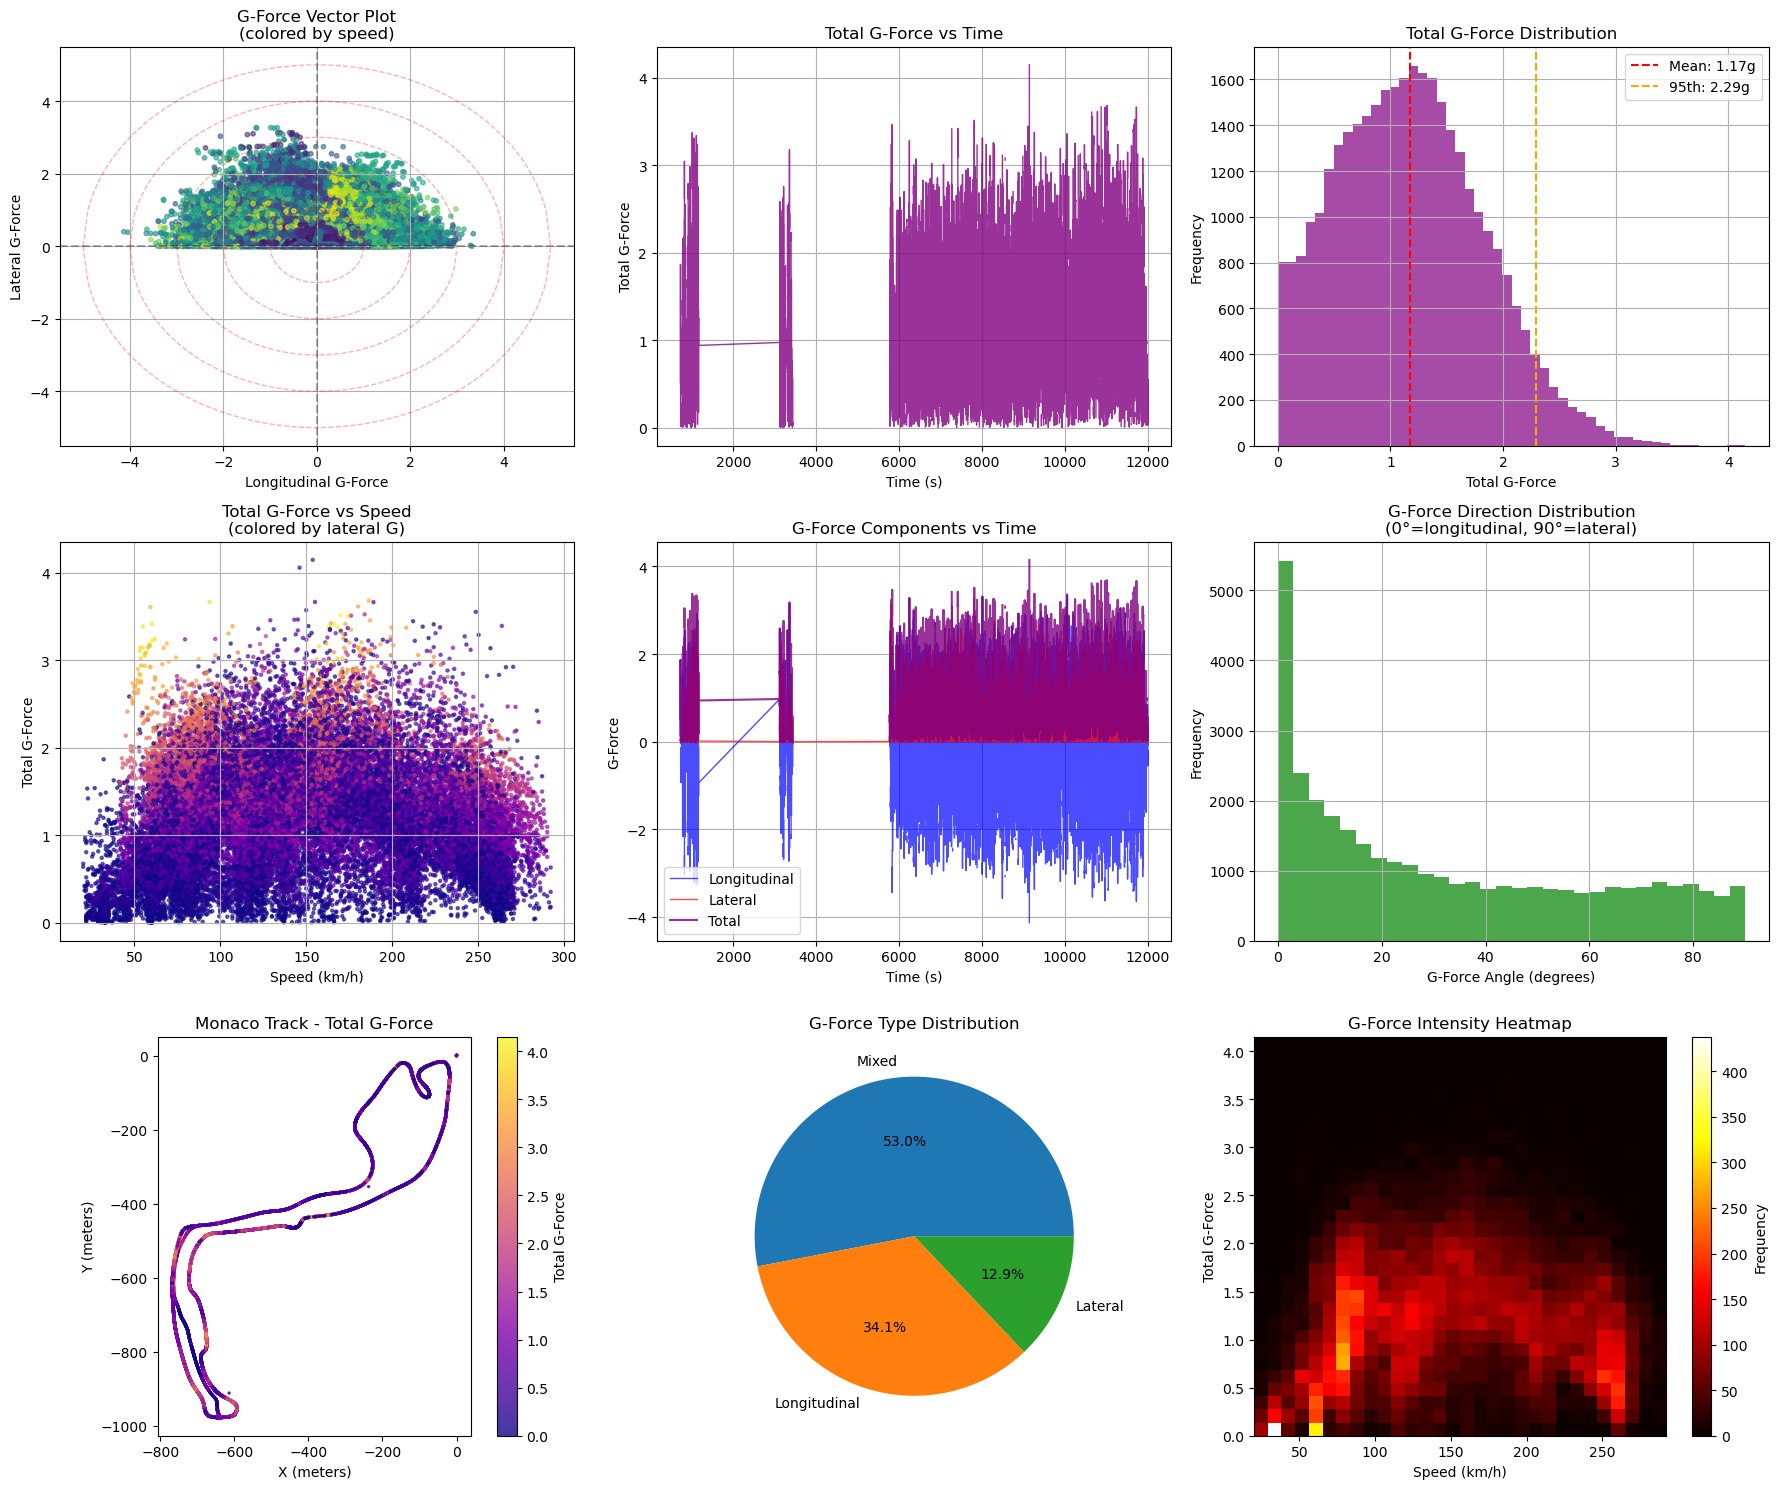

In [73]:
# Create comprehensive plots
plot_combined_gforce_analysis(df_combined)

In [74]:
# Run Monaco insights (this should work)
monaco_gforce_insights(df_combined)


🇲🇨 MONACO COMBINED G-FORCE INSIGHTS:


KeyError: 'g_force_realistic'